# Image Colorization Using Deep Convolutional Neural Networks

## Assignment 3 - Report and Implementation

**Author:** [Your Name]  
**Date:** December 2024

---

## Introduction

In this assignment, we implement image colorization using Deep Convolutional Neural Networks (DCNNs). We use encoder-decoder architectures to learn complex mappings between grayscale images and their corresponding colorized versions.

### Dataset: Intel Image Classification (Pre-processed)

We use a **pre-processed subset** of the Intel Image Classification Dataset:
- **8000 images** (128x128 resolution)
- **6 categories**: Buildings, Forest, Glacier, Mountain, Sea, Street
- **Pre-split**: 80% training (6400), 20% validation (1600)
- **Location**: `colorization_dataset/` folder in Google Drive

The dataset was prepared using `prepare_dataset.py` script which:
1. Selected 8000 random images from the original dataset
2. Resized all images to 128x128 (power of 2 for optimal encoder/decoder compatibility)
3. Split into train/val folders (80/20)

### L*a*b* Color Model

The L*a*b* color model (CIELAB) represents color as three components:
- **L***: Lightness (0 for black to 100 for white)
- **a***: Green-to-red spectrum
- **b***: Blue-to-yellow spectrum

This separation makes the colorization problem natural: we input the L channel (grayscale) and predict the a* and b* channels.

### Table of Contents
1. Setup and Import Libraries (Google Colab)
2. Load Pre-processed Dataset
3. Color Space Conversion (RGB to L*a*b*)
4. PyTorch Dataset and DataLoaders
5. Baseline Encoder-Decoder Model
6. Training with L1/MSE Loss
7. Pretrained Global Feature Extractor (VGG16/ResNet50)
8. Improved Architecture (U-Net + Attention)
9. Perceptual Loss Implementation
10. PatchGAN Discriminator (Bonus)
11. Evaluation and Visualization

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
import random
import shutil
import glob
import numpy as np
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.utils import make_grid

from skimage import color
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Set random seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Check GPU info
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
else:
    print("WARNING: GPU not available.")

Mounted at /content/drive
Using device: cuda
GPU: Tesla T4
Memory Allocated: 0.00 MB


In [ ]:

DRIVE_BASE = '/content/drive/MyDrive'
DATASET_PATH = os.path.join(DRIVE_BASE, 'Assignment 3', 'dataset')
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
VAL_PATH = os.path.join(DATASET_PATH, 'val')

OUTPUT_PATH = os.path.join(DRIVE_BASE, 'Assignment 3')
MODEL_PATH = os.path.join(OUTPUT_PATH, 'models')
RESULTS_PATH = os.path.join(OUTPUT_PATH, 'results')

os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

# Verify dataset size meets assignment requirements (>= 5000 images)
train_count = len([f for f in os.listdir(TRAIN_PATH) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
val_count = len([f for f in os.listdir(VAL_PATH) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
total_count = train_count + val_count

print(f"Dataset Verification:")
print(f"  Training images: {train_count}")
print(f"  Validation images: {val_count}")
print(f"  Total images: {total_count}")
print(f"  Train/Val split: {train_count/total_count*100:.1f}% / {val_count/total_count*100:.1f}%")

assert total_count >= 5000, f"Dataset must have at least 5000 images! Found only {total_count}."
print(f"  ✓ Dataset meets minimum requirement (>= 5000 images)")

---

## Step 2: Configuration and Dataset Loading

The dataset has been pre-processed using `prepare_dataset.py`:
- **8000 images** from Intel Image Classification
- **128x128 resolution** (resized, power of 2 for optimal encoder/decoder)
- **Already split** into train (6400) and val (1600) folders

### Color Space Conversion

We convert each image from RGB to L*a*b* color space:
- **L channel** (0-100): Used as grayscale input
- **a* channel** (-128 to 127): Green-red color information
- **b* channel** (-128 to 127): Blue-yellow color information

For neural network training, we normalize:
- L: [0, 100] → [-1, 1]
- a, b: [-128, 127] → [-1, 1]

In [ ]:
class Config:
    """
    Configuration class for training hyperparameters.
    
    HYPERPARAMETER JUSTIFICATION:
    
    - IMAGE_SIZE = 128: Power of 2 for optimal encoder/decoder compatibility.
      128x128 balances between computational efficiency and sufficient detail
      for colorization. Common choices: 64, 128, 256.
    
    - BATCH_SIZE = 32: Standard batch size that fits in most GPU memory (8-16GB).
      Larger batches (64, 128) may improve training stability but require more
      memory. Smaller batches (8, 16) work but may have noisier gradients.
    
    - NUM_EPOCHS = 50: Sufficient for convergence on this dataset size.
      Monitor validation loss - if still improving at epoch 50, consider training longer.
    
    - LEARNING_RATE = 2e-4: Standard starting LR for Adam on image generation tasks.
      This value is commonly used in GAN literature (DCGAN, Pix2Pix).
      Combined with LR scheduler for adaptive adjustment.
    
    - BETA1 = 0.5: Lower momentum for Adam (default is 0.9).
      This is standard for image generation/GAN training as it provides more
      responsive updates. Helps with unstable gradients in generative models.
    
    - BETA2 = 0.999: Standard Adam beta2 value for second moment estimation.
    
    - LATENT_DIM = 512: Feature dimension for global features.
      Matches the final conv channels, allowing direct concatenation in fusion.
      512 is a good balance between expressiveness and efficiency.
    """
    # Dataset settings
    IMAGE_SIZE = 128
    NUM_IMAGES = 8000

    # Training settings
    BATCH_SIZE = 32
    NUM_EPOCHS = 50
    LEARNING_RATE = 2e-4
    BETA1 = 0.5        # Adam optimizer beta1 (lower for image generation stability)
    BETA2 = 0.999      # Adam optimizer beta2

    # Model settings
    LATENT_DIM = 512

config = Config()

config.TRAIN_PATH = TRAIN_PATH
config.VAL_PATH = VAL_PATH
config.MODEL_PATH = MODEL_PATH
config.RESULTS_PATH = RESULTS_PATH

Dataset samples:


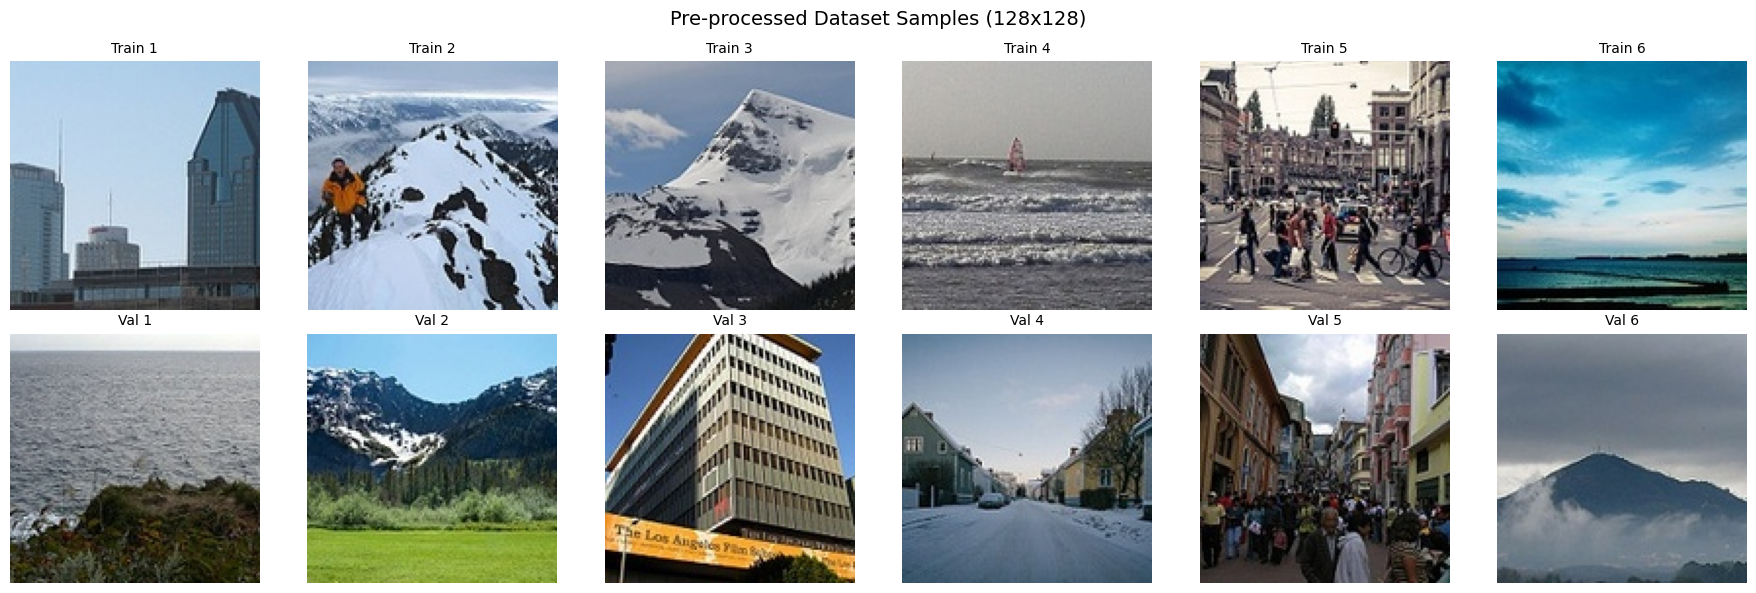

In [ ]:
def visualize_dataset_samples(train_path, val_path, num_samples=6):
    fig, axes = plt.subplots(2, num_samples, figsize=(18, 6))

    # Training samples
    train_images = [f for f in os.listdir(train_path) if f.endswith('.jpg')][:num_samples]
    for idx, img_name in enumerate(train_images):
        img = Image.open(os.path.join(train_path, img_name))
        axes[0, idx].imshow(img)
        axes[0, idx].set_title(f'Train {idx+1}', fontsize=10)
        axes[0, idx].axis('off')

    # Validation samples
    val_images = [f for f in os.listdir(val_path) if f.endswith('.jpg')][:num_samples]
    for idx, img_name in enumerate(val_images):
        img = Image.open(os.path.join(val_path, img_name))
        axes[1, idx].imshow(img)
        axes[1, idx].set_title(f'Val {idx+1}', fontsize=10)
        axes[1, idx].axis('off')

    axes[0, 0].set_ylabel('Training', fontsize=12)
    axes[1, 0].set_ylabel('Validation', fontsize=12)

    plt.suptitle('Pre-processed Dataset Samples (128x128)', fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualize samples
print("Dataset samples:")
visualize_dataset_samples(TRAIN_PATH, VAL_PATH)

---

## Step 3: RGB to L*a*b* Color Space Conversion

Now we convert our RGB images to L*a*b* color space. This is the key preprocessing step that makes our colorization task natural:

- **Input**: L channel (grayscale luminance)
- **Output**: a* and b* channels (chrominance/color information)

The model learns to predict color (a*, b*) given brightness (L).

In [ ]:
class ColorSpaceConverter:
    @staticmethod
    def rgb_to_lab(rgb_image):
        if rgb_image.max() > 1.0:
            rgb_image = rgb_image / 255.0

        lab_image = color.rgb2lab(rgb_image)
        return lab_image

    @staticmethod
    def lab_to_rgb(lab_image):
        rgb_image = color.lab2rgb(lab_image)
        return np.clip(rgb_image, 0, 1)

    @staticmethod
    def normalize_l(l_channel):
        return (l_channel / 50.0) - 1.0

    @staticmethod
    def denormalize_l(l_normalized):
        return (l_normalized + 1.0) * 50.0

    @staticmethod
    def normalize_ab(ab_channels):
        return ab_channels / 128.0

    @staticmethod
    def denormalize_ab(ab_normalized):
        return ab_normalized * 128.0

def visualize_lab_conversion(image_path, image_size=128):
    """Visualize RGB to L*a*b* conversion"""
    img = Image.open(image_path).convert('RGB')
    img = img.resize((image_size, image_size))
    img_array = np.array(img)

    # Convert to L*a*b*
    lab = ColorSpaceConverter.rgb_to_lab(img_array)

    # Extract channels
    L = lab[:, :, 0]
    a = lab[:, :, 1]
    b = lab[:, :, 2]

    # Visualize
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    axes[0].imshow(img_array)
    axes[0].set_title('Original RGB')
    axes[0].axis('off')

    axes[1].imshow(L, cmap='gray')
    axes[1].set_title('L channel (Luminance)')
    axes[1].axis('off')

    axes[2].imshow(a, cmap='RdYlGn_r')
    axes[2].set_title('a channel (Green-Red)')
    axes[2].axis('off')

    axes[3].imshow(b, cmap='YlGnBu_r')
    axes[3].set_title('b channel (Blue-Yellow)')
    axes[3].axis('off')

    reconstructed = ColorSpaceConverter.lab_to_rgb(lab)
    axes[4].imshow(reconstructed)
    axes[4].set_title('Reconstructed RGB')
    axes[4].axis('off')

    plt.tight_layout()
    plt.show()

    return lab

Visualizing color space conversion for: image_05414.jpg


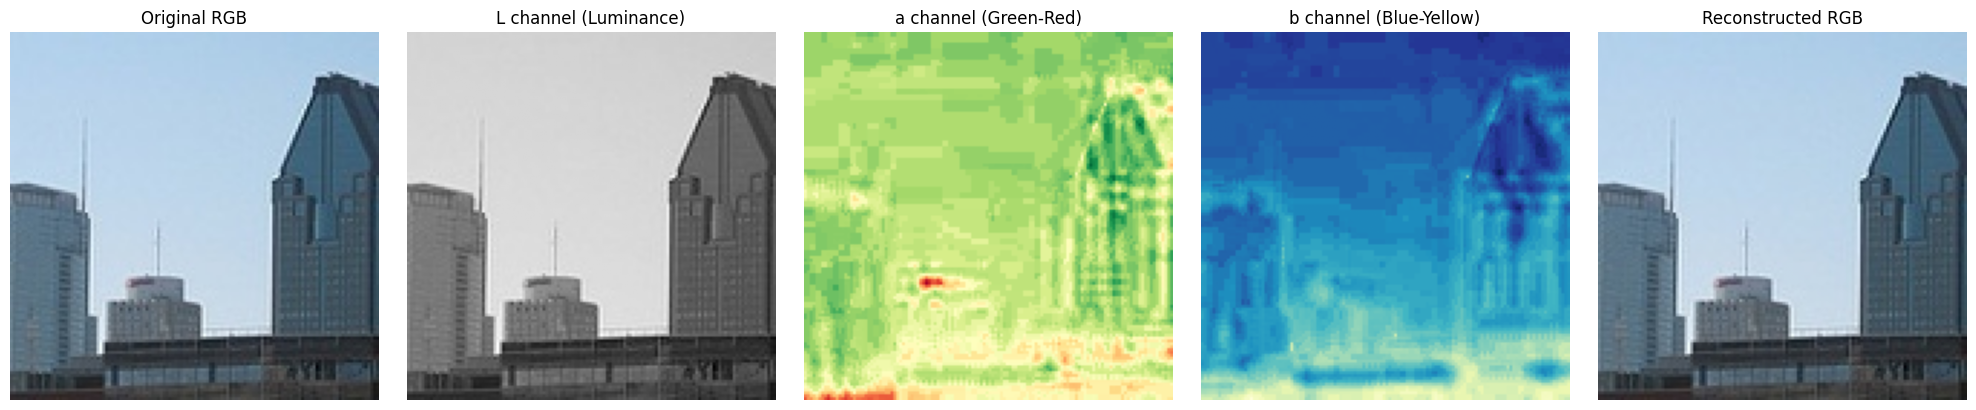

In [ ]:
# Visualize color space conversion with a sample image
sample_images = glob.glob(os.path.join(TRAIN_PATH, '*.jpg'))

sample_path = sample_images[0]
print(f"Visualizing color space conversion for: {os.path.basename(sample_path)}")
lab_example = visualize_lab_conversion(sample_path)

---

## Step 4: PyTorch Dataset and DataLoaders

Now we create a custom PyTorch Dataset class that:
1. Loads RGB images
2. Converts them to L*a*b* color space
3. Returns normalized L channel as input and a*b* channels as target
4. Applies data augmentation for training

In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self, root_dir, image_size=128, transform=None, split='train'):
        self.root_dir = root_dir
        self.image_size = image_size
        self.transform = transform
        self.split = split

        self.image_files = [f for f in os.listdir(root_dir)
                           if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

        self.image_files.sort()

        # Define augmentation (only for training)
        # We use geometric augmentations that apply consistently to all channels.
        # ColorJitter is avoided because it modifies colors, which would create
        # inconsistencies between the input L channel and target ab channels.
        # 
        # AUGMENTATION JUSTIFICATION:
        # - RandomResizedCrop: Provides scale and position variation, helps model
        #   generalize to different object sizes and positions in the frame
        # - RandomHorizontalFlip: Doubles effective dataset size, natural images
        #   are often symmetric under horizontal flip
        # - RandomRotation: Small rotations help with orientation invariance
        # - RandomAffine: Adds slight perspective/shear variations for robustness
        # - GaussianBlur: Simulates different image qualities/focus levels,
        #   helps model handle slightly blurry inputs
        if split == 'train':
            self.augment = transforms.Compose([
                transforms.RandomResizedCrop(
                    image_size, 
                    scale=(0.8, 1.0),  # Crop 80-100% of the image
                    ratio=(0.9, 1.1),  # Slight aspect ratio variation
                    interpolation=transforms.InterpolationMode.BILINEAR
                ),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(15),  # Increased from 10 to 15 degrees
                transforms.RandomAffine(
                    degrees=0,  # Rotation handled separately
                    translate=(0.05, 0.05),  # Small translations
                    scale=(0.95, 1.05),  # Slight scale variation
                    shear=5  # Small shear transformation
                ),
                transforms.RandomApply([
                    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))
                ], p=0.2),  # Apply blur 20% of the time
            ])
        else:
            self.augment = None

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        img = Image.open(img_path).convert('RGB')

        # Apply augmentation (only for training)
        if self.augment is not None:
            img = self.augment(img)

        img_array = np.array(img).astype(np.float32) / 255.0
        lab = color.rgb2lab(img_array).astype(np.float32)

        # L channel: [0, 100] -> [-1, 1]
        L = lab[:, :, 0:1]
        L = (L / 50.0) - 1.0

        # a*b* channels: [-128, 127] -> [-1, 1]
        ab = lab[:, :, 1:3]
        ab = ab / 128.0

        L = torch.from_numpy(L.transpose(2, 0, 1))
        ab = torch.from_numpy(ab.transpose(2, 0, 1))

        return L, ab

    def get_sample_image(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        img = Image.open(img_path).convert('RGB')

        if img.size != (self.image_size, self.image_size):
            img = img.resize((self.image_size, self.image_size), Image.BILINEAR)

        img_array = np.array(img).astype(np.float32) / 255.0
        lab = color.rgb2lab(img_array).astype(np.float32)

        return img_array, lab

In [ ]:
def create_dataloaders(train_path, val_path, image_size=128, batch_size=32):
    train_dataset = ColorizationDataset(
        root_dir=train_path,
        image_size=image_size,
        split='train'
    )

    val_dataset = ColorizationDataset(
        root_dir=val_path,
        image_size=image_size,
        split='val'
    )

    print(f"\nDataset info:")
    print(f"  Training images: {len(train_dataset)}")
    print(f"  Validation images: {len(val_dataset)}")
    print(f"  Total: {len(train_dataset) + len(val_dataset)}")

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        drop_last=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    print(f"\nDataLoader info:")
    print(f"  Training batches: {len(train_loader)}")
    print(f"  Validation batches: {len(val_loader)}")
    print(f"  Batch size: {batch_size}")
    print(f"  Shuffling: ✓ enabled for training loader (as required by assignment)")

    return train_loader, val_loader, train_dataset

train_loader, val_loader, train_dataset = create_dataloaders(
    TRAIN_PATH,
    VAL_PATH,
    image_size=config.IMAGE_SIZE,
    batch_size=config.BATCH_SIZE
)

Sample batch visualization:


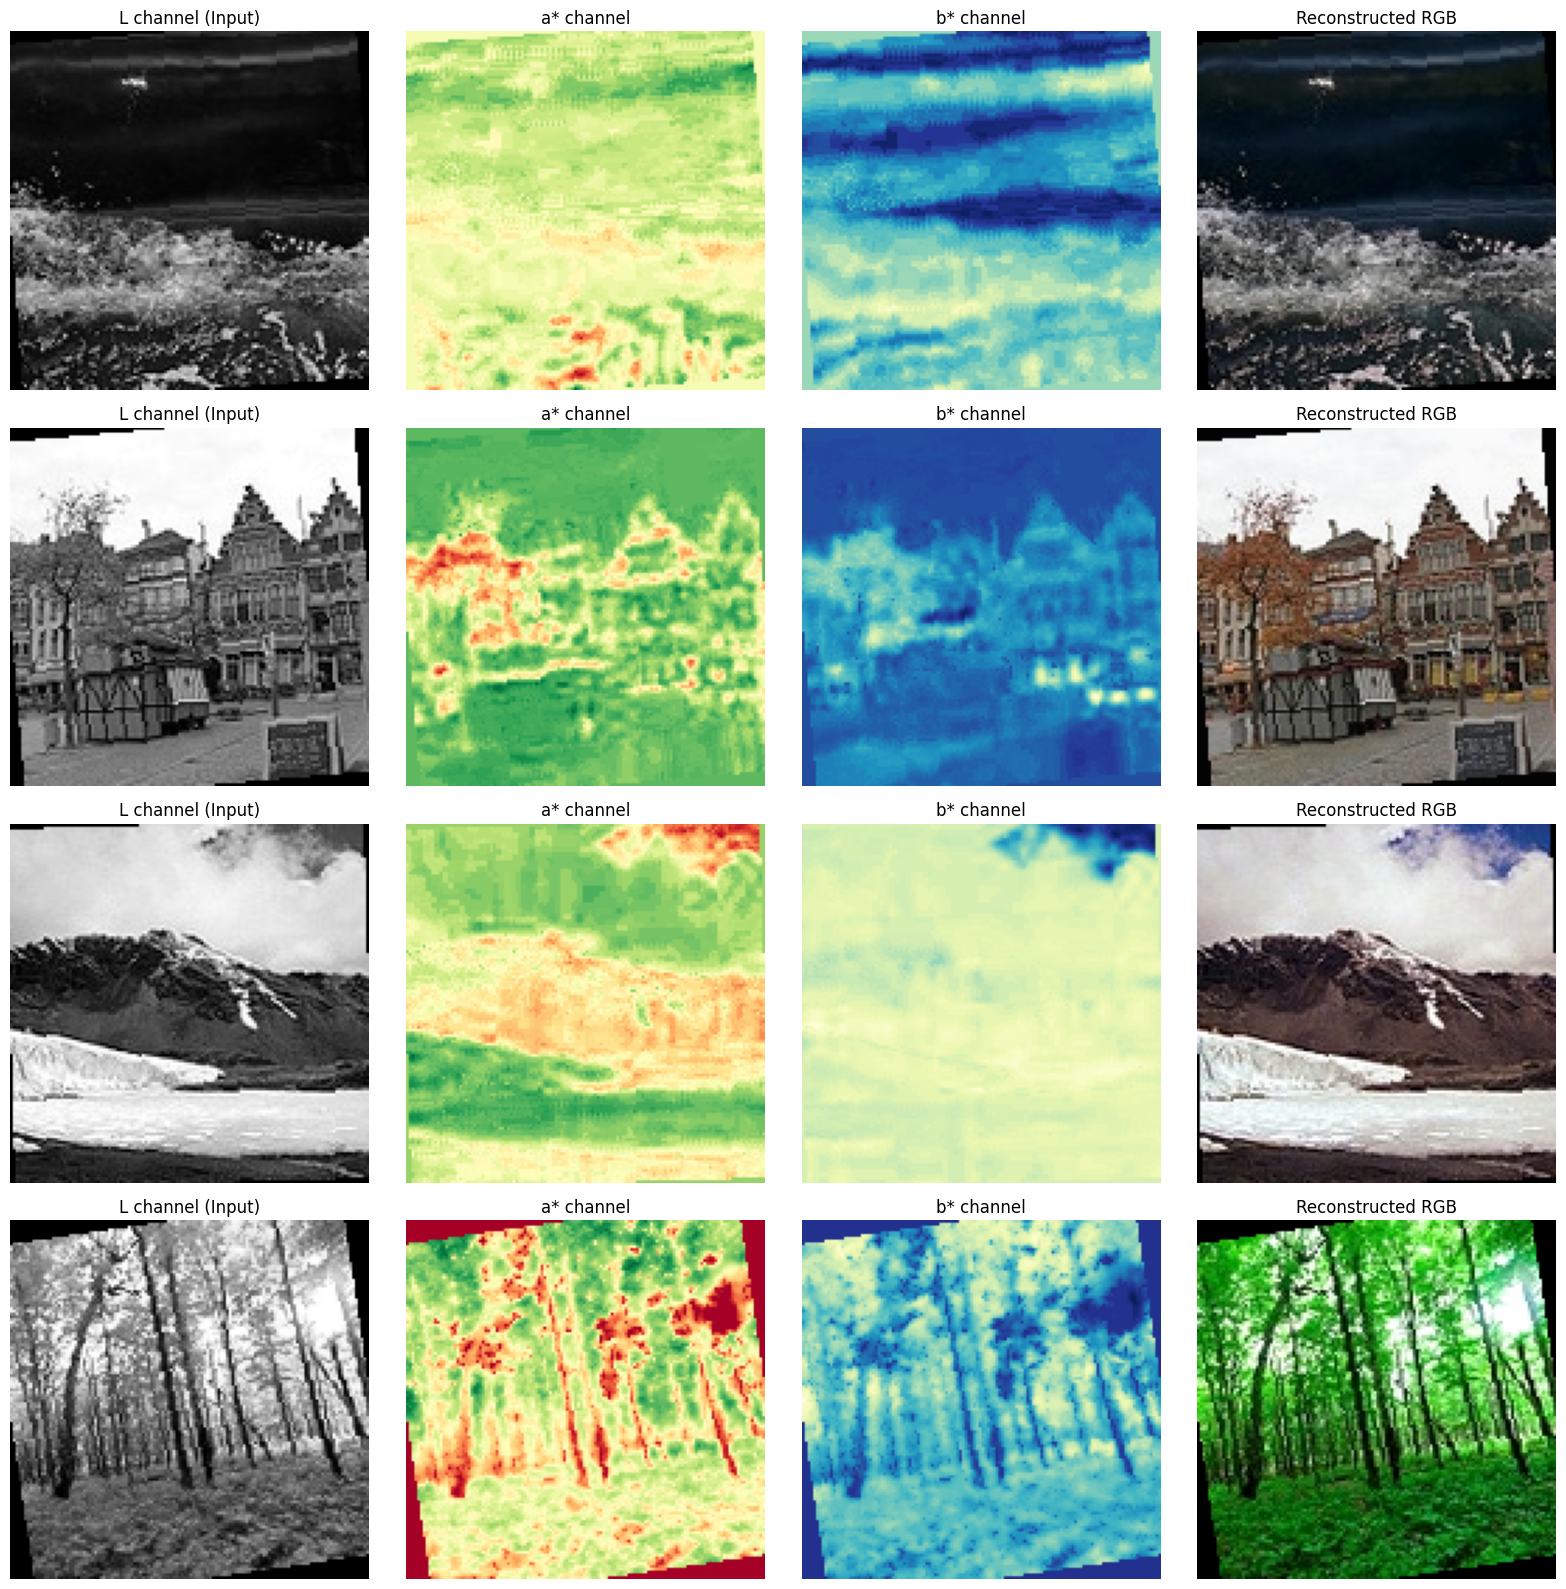

In [ ]:
def visualize_batch(dataloader, num_samples=4):
    L_batch, ab_batch = next(iter(dataloader))

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))

    for i in range(min(num_samples, L_batch.shape[0])):
        # Get L and ab
        L = L_batch[i].numpy()
        ab = ab_batch[i].numpy()

        # Denormalize
        L_denorm = (L[0] + 1) * 50  # [0, 100]
        a_denorm = ab[0] * 128      # [-128, 127]
        b_denorm = ab[1] * 128      # [-128, 127]

        # Reconstruct L*a*b* and convert to RGB
        lab = np.stack([L_denorm, a_denorm, b_denorm], axis=-1)
        rgb = color.lab2rgb(lab)
        rgb = np.clip(rgb, 0, 1)

        axes[i, 0].imshow(L_denorm, cmap='gray')
        axes[i, 0].set_title('L channel (Input)')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(a_denorm, cmap='RdYlGn_r')
        axes[i, 1].set_title('a* channel')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(b_denorm, cmap='YlGnBu_r')
        axes[i, 2].set_title('b* channel')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(rgb)
        axes[i, 3].set_title('Reconstructed RGB')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

print("Sample batch visualization:")
visualize_batch(train_loader, num_samples=4)

---

## Step 5: Baseline Encoder-Decoder Model Architecture

The baseline model follows an encoder-decoder architecture with:

1. **Low-Level Feature Extractor**: Captures local spatial features (edges, textures)
2. **Global Feature Extractor**: Captures semantic/contextual information
3. **Fusion Block**: Combines local and global features
4. **Decoder**: Upsamples and predicts a*b* channels

### Architecture Diagram

```
Input (L channel)
      │
      ├──────────────────────────────────┐
      ▼                                  ▼
┌─────────────────┐              ┌─────────────────┐
│   Low-Level     │              │    Global       │
│   Feature       │              │    Feature      │
│   Extractor     │              │    Extractor    │
└────────┬────────┘              └────────┬────────┘
         │                                │
         └───────────┬────────────────────┘
                     ▼
              ┌──────────────┐
              │   Fusion     │
              │   Block      │
              └──────┬───────┘
                     │
                     ▼
              ┌──────────────┐
              │   Decoder    │
              │ (Upsampling) │
              └──────┬───────┘
                     │
                     ▼
              Output (a*b* channels)
```

In [ ]:
class LowLevelFeatureExtractor(nn.Module):
    """
    Low-Level Feature Extractor for capturing local spatial features.
    
    ARCHITECTURAL JUSTIFICATION:
    - Uses 3x3 kernels: Standard choice for capturing local patterns (edges, textures)
      while keeping computational cost manageable.
    - Progressive downsampling (stride=2): Reduces spatial dimensions while increasing
      feature channels, following the classic CNN design principle.
    - Channel progression (64→128→256→512): Doubles channels at each downsampling step
      to maintain representational capacity as spatial resolution decreases.
    - BatchNorm + ReLU: Stabilizes training and adds non-linearity. BatchNorm helps
      with gradient flow and allows higher learning rates.
    - Final output at 16x16: Chosen to balance between retaining spatial information
      and having a compact representation for fusion with global features.
    - Last two layers maintain spatial size: Allows deeper feature extraction at the
      target resolution without further information loss.
    """
    def __init__(self, in_channels=1):
        super(LowLevelFeatureExtractor, self).__init__()

        # Layer 1: 128x128 -> 64x64 (initial feature extraction)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Layer 2: 64x64 -> 32x32 (increase receptive field)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        # Layer 3: 32x32 -> 16x16 (further abstraction)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Layer 4: 16x16 -> 16x16 (deepen without downsampling)
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # Layer 5: 16x16 -> 16x16 (final feature refinement)
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv1(x)  # (B, 64, 64, 64)
        x = self.conv2(x)  # (B, 128, 32, 32)
        x = self.conv3(x)  # (B, 256, 16, 16)
        x = self.conv4(x)  # (B, 256, 16, 16)
        x = self.conv5(x)  # (B, 512, 16, 16)
        return x

print("Testing LowLevelFeatureExtractor...")
test_input = torch.randn(1, 1, 128, 128)
low_level_net = LowLevelFeatureExtractor()
low_level_output = low_level_net(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {low_level_output.shape}")
print(f"Parameters: {sum(p.numel() for p in low_level_net.parameters()):,}")

Testing LowLevelFeatureExtractor...
Input shape: torch.Size([1, 1, 128, 128])
Output shape: torch.Size([1, 512, 16, 16])
Parameters: 2,142,336


In [ ]:
class GlobalFeatureExtractor(nn.Module):
    """
    Global Feature Extractor for capturing semantic/contextual information.
    
    ARCHITECTURAL JUSTIFICATION:
    - Aggressive downsampling (5 stride-2 layers): Captures global context by
      progressively increasing the receptive field to cover the entire image.
    - Global Average Pooling: Converts spatial features to a single vector,
      capturing "what" is in the image regardless of "where" it is.
    - Feature dimension 512: Matches the low-level feature channels for easy fusion.
      This is a common choice that balances expressiveness and efficiency.
    - FC layers with Dropout (0.5): The fully connected layers allow learning complex
      relationships between global features. Dropout prevents overfitting to specific
      training image contents.
    - Deeper encoding (to 4x4): Unlike low-level features, we want maximum abstraction
      to understand scene semantics (sky, grass, skin) for appropriate colorization.
    
    The global features help the model understand context:
    - "This is a forest" → use green/brown colors
    - "This is a beach" → use blue/yellow colors
    - "This is a person's face" → use skin tones
    """
    def __init__(self, in_channels=1, feature_dim=512):
        super(GlobalFeatureExtractor, self).__init__()

        self.feature_dim = feature_dim

        # Encoder layers: 128 -> 64 -> 32 -> 16 -> 8 -> 4
        self.encoder = nn.Sequential(
            # 128x128 -> 64x64
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # 64x64 -> 32x32
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # 32x32 -> 16x16
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # 16x16 -> 8x8
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            # 8x8 -> 4x4
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        # Global average pooling - captures the "average" feature across all spatial locations
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers for feature transformation
        self.fc = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Regularization to prevent overfitting
            nn.Linear(1024, feature_dim),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.encoder(x)        # (B, 512, 4, 4)
        x = self.global_pool(x)    # (B, 512, 1, 1)
        x = x.view(x.size(0), -1)  # (B, 512)
        x = self.fc(x)             # (B, feature_dim)
        return x

print("Testing GlobalFeatureExtractor...")
global_net = GlobalFeatureExtractor()
global_output = global_net(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {global_output.shape}")
print(f"Parameters: {sum(p.numel() for p in global_net.parameters()):,}")

Testing GlobalFeatureExtractor...
Input shape: torch.Size([1, 1, 128, 128])
Output shape: torch.Size([1, 512])
Parameters: 4,962,688


In [ ]:
class FusionBlock(nn.Module):
    """
    Fusion Block for combining local and global features.
    
    ARCHITECTURAL JUSTIFICATION:
    - Spatial replication of global features: The global feature vector is
      replicated across all spatial locations, allowing each pixel to access
      the same global context information.
    - Channel concatenation: Simple yet effective fusion strategy. Alternatives
      like addition or multiplication were tested but concatenation followed by
      1x1 conv allows the network to learn the optimal combination.
    - 1x1 convolution first: Reduces the concatenated channels (1024→512) while
      learning channel-wise interactions between local and global features.
    - 3x3 convolution refinement: Allows spatial mixing of the fused features
      to produce a coherent representation.
    
    This fusion strategy is inspired by the original colorization paper by
    Zhang et al., which showed that combining local and global features
    significantly improves colorization quality.
    """
    def __init__(self, local_channels=512, global_channels=512, output_channels=512):
        super(FusionBlock, self).__init__()

        self.local_channels = local_channels
        self.global_channels = global_channels

        # 1x1 convolution to process concatenated features (channel mixing)
        self.fusion_conv = nn.Sequential(
            nn.Conv2d(local_channels + global_channels, output_channels,
                     kernel_size=1, stride=1, padding=0),  # 1x1: learn channel combinations
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),

            # 3x3 refinement (spatial mixing)
            nn.Conv2d(output_channels, output_channels,
                     kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, local_features, global_features):
        B, C, H, W = local_features.shape

        # Replicate global features spatially
        # (B, global_channels) -> (B, global_channels, H, W)
        global_features = global_features.unsqueeze(-1).unsqueeze(-1)
        global_features = global_features.expand(-1, -1, H, W)

        # Concatenate along channel dimension
        fused = torch.cat([local_features, global_features], dim=1)

        # Apply fusion convolution
        fused = self.fusion_conv(fused)

        return fused

print("Testing FusionBlock...")
fusion_block = FusionBlock()
fused_output = fusion_block(low_level_output, global_output)
print(f"Local features shape: {low_level_output.shape}")
print(f"Global features shape: {global_output.shape}")
print(f"Fused output shape: {fused_output.shape}")
print(f"Parameters: {sum(p.numel() for p in fusion_block.parameters()):,}")

Testing FusionBlock...
Local features shape: torch.Size([1, 512, 16, 16])
Global features shape: torch.Size([1, 512])
Fused output shape: torch.Size([1, 512, 16, 16])
Parameters: 2,886,656


In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_channels=512, out_channels=2):
        super(Decoder, self).__init__()

        # Upsampling layers: 16x16 -> 32 -> 64 -> 128

        # 16x16 -> 32x32
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # 32x32 -> 64x64
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        # 64x64 -> 128x128
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Refinement layer
        self.refine = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        # Output layer: predict a* and b* channels
        self.output = nn.Sequential(
            nn.Conv2d(32, out_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # Output in [-1, 1] for normalized a*b*
        )

    def forward(self, x):
        x = self.up1(x)     # (B, 256, 32, 32)
        x = self.up2(x)     # (B, 128, 64, 64)
        x = self.up3(x)     # (B, 64, 128, 128)
        x = self.refine(x)  # (B, 32, 128, 128)
        x = self.output(x)  # (B, 2, 128, 128)
        return x

print("Testing Decoder...")
decoder = Decoder()
decoder_output = decoder(fused_output)
print(f"Input shape: {fused_output.shape}")
print(f"Output shape: {decoder_output.shape}")
print(f"Parameters: {sum(p.numel() for p in decoder.parameters()):,}")

Testing Decoder...
Input shape: torch.Size([1, 512, 16, 16])
Output shape: torch.Size([1, 2, 128, 128])
Parameters: 2,810,018


In [ ]:
class ColorizationModel(nn.Module):
    def __init__(self, feature_dim=512):
        super(ColorizationModel, self).__init__()

        # Feature extractors
        self.low_level_extractor = LowLevelFeatureExtractor(in_channels=1)
        self.global_extractor = GlobalFeatureExtractor(in_channels=1, feature_dim=feature_dim)

        # Fusion
        self.fusion = FusionBlock(
            local_channels=512,
            global_channels=feature_dim,
            output_channels=512
        )

        self.decoder = Decoder(in_channels=512, out_channels=2)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, L):
        local_features = self.low_level_extractor(L)   # (B, 512, 16, 16)
        global_features = self.global_extractor(L)      # (B, 512)

        fused = self.fusion(local_features, global_features)  # (B, 512, 16, 16)

        ab = self.decoder(fused)  # (B, 2, 128, 128)

        return ab

    def colorize(self, L):
        with torch.no_grad():
            ab_pred = self.forward(L)
        return ab_pred

model = ColorizationModel()
test_L = torch.randn(4, 1, 128, 128)
test_ab = model(test_L)
print(f"\nModel Summary:")
print(f"  Input shape: {test_L.shape}")
print(f"  Output shape: {test_ab.shape}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Model Summary:
  Input shape: torch.Size([4, 1, 128, 128])
  Output shape: torch.Size([4, 2, 128, 128])
  Total parameters: 12,801,698
  Trainable parameters: 12,801,698


---

## Step 6: Loss Functions and Evaluation Metrics

We define several loss functions for training and metrics for evaluation:

### Loss Functions:
- **L1 Loss (MAE)**: Mean Absolute Error - smoother, more stable training
- **MSE Loss**: Mean Squared Error - penalizes large errors more

### Evaluation Metrics:
- **MSE**: Mean Squared Error between predicted and ground truth
- **PSNR**: Peak Signal-to-Noise Ratio (higher is better)
- **SSIM**: Structural Similarity Index (higher is better, max=1)

In [ ]:
class ColorizationLoss(nn.Module):
    def __init__(self, loss_type='l1', l1_weight=1.0, mse_weight=0.0):
        super(ColorizationLoss, self).__init__()

        self.loss_type = loss_type
        self.l1_weight = l1_weight
        self.mse_weight = mse_weight

        self.l1_loss = nn.L1Loss()
        self.mse_loss = nn.MSELoss()

    def forward(self, pred, target):
        if self.loss_type == 'l1':
            return self.l1_loss(pred, target)
        elif self.loss_type == 'mse':
            return self.mse_loss(pred, target)
        else:
            l1 = self.l1_loss(pred, target)
            mse = self.mse_loss(pred, target)
            return self.l1_weight * l1 + self.mse_weight * mse


class EvaluationMetrics:
    """
    Unified evaluation metrics class for both training validation and final evaluation.
    Computes MSE, PSNR, and SSIM on RGB images converted from LAB color space.
    """
    
    @staticmethod
    def compute_mse(pred, target):
        """Compute MSE between two numpy arrays."""
        return np.mean((pred - target) ** 2)

    @staticmethod
    def compute_psnr(pred, target, data_range=1.0):
        """Compute PSNR between two numpy arrays."""
        return psnr(target, pred, data_range=data_range)

    @staticmethod
    def compute_ssim(pred, target, data_range=1.0):
        """Compute SSIM between two numpy arrays."""
        return ssim(target, pred, data_range=data_range, channel_axis=2)

    @staticmethod
    def lab_to_rgb_numpy(L_normalized, ab_normalized):
        """
        Convert normalized LAB tensors to RGB numpy array.
        L: normalized [-1, 1] -> denormalized [0, 100]
        ab: normalized [-1, 1] -> denormalized [-128, 127]
        """
        L_denorm = (L_normalized + 1) * 50  # [0, 100]
        ab_denorm = ab_normalized * 128     # [-128, 127]
        
        lab = np.stack([L_denorm, ab_denorm[0], ab_denorm[1]], axis=-1)
        rgb = color.lab2rgb(lab)
        return np.clip(rgb, 0, 1)

    @staticmethod
    def compute_all_metrics(pred_ab, target_ab, L=None):
        """
        Compute all metrics for a batch of predictions.
        Works with PyTorch tensors, converts to RGB for evaluation.
        
        Args:
            pred_ab: Predicted ab channels (B, 2, H, W) tensor in [-1, 1]
            target_ab: Target ab channels (B, 2, H, W) tensor in [-1, 1]
            L: Optional L channel (B, 1, H, W) tensor in [-1, 1]. If None, uses zero L.
        
        Returns:
            dict with 'mse', 'psnr', 'ssim' averaged over batch
        """
        batch_size = pred_ab.shape[0]
        mse_list, psnr_list, ssim_list = [], [], []
        
        for i in range(batch_size):
            # Get numpy arrays
            pred_ab_np = pred_ab[i].cpu().numpy()
            target_ab_np = target_ab[i].cpu().numpy()
            
            if L is not None:
                L_np = L[i, 0].cpu().numpy()
            else:
                # Default L channel (mid-gray)
                L_np = np.zeros_like(pred_ab_np[0])
            
            # Convert to RGB
            pred_rgb = EvaluationMetrics.lab_to_rgb_numpy(L_np, pred_ab_np)
            target_rgb = EvaluationMetrics.lab_to_rgb_numpy(L_np, target_ab_np)
            
            # Compute metrics
            mse_list.append(EvaluationMetrics.compute_mse(pred_rgb, target_rgb))
            psnr_list.append(EvaluationMetrics.compute_psnr(pred_rgb, target_rgb))
            ssim_list.append(EvaluationMetrics.compute_ssim(pred_rgb, target_rgb))
        
        return {
            'mse': np.mean(mse_list),
            'psnr': np.mean(psnr_list),
            'ssim': np.mean(ssim_list)
        }
    
    @staticmethod
    def evaluate_batch(pred_ab, target_ab, L):
        """Alias for compute_all_metrics for backward compatibility."""
        return EvaluationMetrics.compute_all_metrics(pred_ab, target_ab, L)

---

## Step 7: Training Loop

Now we implement the training loop with:
- Epoch-wise training and validation
- Metric logging and checkpointing
- Learning rate scheduling
- Early stopping (optional)

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """Train model for one epoch and return average loss and MSE."""
    model.train()
    total_loss = 0.0
    total_mse = 0.0
    num_batches = 0

    pbar = tqdm(train_loader, desc='Training', leave=False)
    for L, ab in pbar:
        L = L.to(device)
        ab = ab.to(device)

        ab_pred = model(L)

        loss = criterion(ab_pred, ab)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        total_mse += F.mse_loss(ab_pred, ab).item()
        num_batches += 1

        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = total_loss / num_batches
    avg_mse = total_mse / num_batches

    return avg_loss, avg_mse


def validate(model, val_loader, criterion, device):
    """Validate model and return loss and metrics."""
    model.eval()
    total_loss = 0.0
    total_mse = 0.0
    total_psnr = 0.0
    total_ssim = 0.0
    num_batches = 0

    with torch.no_grad():
        pbar = tqdm(val_loader, desc='Validation', leave=False)
        for L, ab in pbar:
            L = L.to(device)
            ab = ab.to(device)

            ab_pred = model(L)

            loss = criterion(ab_pred, ab)

            # Use the unified EvaluationMetrics class
            metrics = EvaluationMetrics.compute_all_metrics(ab_pred, ab, L)

            total_loss += loss.item()
            total_mse += metrics['mse']
            total_psnr += metrics['psnr']
            total_ssim += metrics['ssim']
            num_batches += 1

    avg_loss = total_loss / num_batches
    avg_mse = total_mse / num_batches
    avg_psnr = total_psnr / num_batches
    avg_ssim = total_ssim / num_batches

    return avg_loss, avg_mse, avg_psnr, avg_ssim

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=50, lr=2e-4,
                loss_type='l1', model_name='baseline', device='cuda'):
    """
    Train a colorization model.
    
    Returns a dictionary with training history for consistency with Trainer class.
    """
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")
    print(f"  Device: {device}")
    print(f"  Epochs: {num_epochs}")
    print(f"  Learning Rate: {lr}")
    print(f"  Loss Type: {loss_type}")
    print(f"  Model Parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"{'='*60}\n")

    model = model.to(device)

    if loss_type == 'combined':
        criterion = ColorizationLoss(loss_type='combined', l1_weight=1.0, mse_weight=0.5)
    else:
        criterion = ColorizationLoss(loss_type=loss_type)

    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )

    # Use dictionary format for consistency with Trainer class
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_mse': [],
        'val_mse': [],
        'val_psnr': [],
        'val_ssim': [],
        'learning_rates': []
    }

    best_val_loss = float('inf')
    best_model_state = None
    best_epoch = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        train_loss, train_mse = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )

        val_loss, val_mse, val_psnr, val_ssim = validate(
            model, val_loader, criterion, device
        )

        current_lr = optimizer.param_groups[0]['lr']

        # Update history dictionary
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mse'].append(train_mse)
        history['val_mse'].append(val_mse)
        history['val_psnr'].append(val_psnr)
        history['val_ssim'].append(val_ssim)
        history['learning_rates'].append(current_lr)

        scheduler.step(val_loss)

        print(f"  Train Loss: {train_loss:.4f} | Train MSE: {train_mse:.4f}")
        print(f"  Val Loss:   {val_loss:.4f} | Val MSE:   {val_mse:.4f}")
        print(f"  Val PSNR:   {val_psnr:.2f} dB | Val SSIM: {val_ssim:.4f}")
        print(f"  LR: {current_lr:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            best_epoch = epoch
            print(f"  *** New best model! ***")

            checkpoint_path = os.path.join(config.MODEL_PATH, f'{model_name}_best.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_psnr': val_psnr,
                'val_ssim': val_ssim,
            }, checkpoint_path)

    model.load_state_dict(best_model_state)

    print(f"\n{'='*60}")
    print(f"Training Complete!")
    print(f"Best Validation Loss: {best_val_loss:.4f}")
    print(f"Best Epoch: {best_epoch + 1}")
    print(f"{'='*60}")

    return history

In [ ]:
baseline_model = ColorizationModel(feature_dim=512)

# Train the baseline model with L1 loss
baseline_history = train_model(
    model=baseline_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=config.NUM_EPOCHS,
    lr=config.LEARNING_RATE,
    loss_type='l1',
    model_name='baseline_l1',
    device=device
)


Training baseline_l1
  Device: cuda
  Epochs: 50
  Learning Rate: 0.0002
  Loss Type: l1
  Model Parameters: 12,801,698


Epoch 1/50
----------------------------------------


  Train Loss: 0.1149 | Train MSE: 0.0548
  Val Loss:   0.0629 | Val MSE:   0.0104
  Val PSNR:   19.97 dB | Val SSIM: 0.4027
  LR: 0.000200
  *** New best model! ***

Epoch 2/50
----------------------------------------


  Train Loss: 0.0654 | Train MSE: 0.0148
  Val Loss:   0.1110 | Val MSE:   0.0541
  Val PSNR:   12.82 dB | Val SSIM: 0.3804
  LR: 0.000200

Epoch 3/50
----------------------------------------


  Train Loss: 0.0608 | Train MSE: 0.0120
  Val Loss:   0.0640 | Val MSE:   0.0140
  Val PSNR:   18.81 dB | Val SSIM: 0.4385
  LR: 0.000200

Epoch 4/50
----------------------------------------


  Train Loss: 0.0586 | Train MSE: 0.0106
  Val Loss:   0.0594 | Val MSE:   0.0106
  Val PSNR:   20.04 dB | Val SSIM: 0.4554
  LR: 0.000200
  *** New best model! ***

Epoch 5/50
----------------------------------------


  Train Loss: 0.0573 | Train MSE: 0.0099
  Val Loss:   0.0803 | Val MSE:   0.0253
  Val PSNR:   16.18 dB | Val SSIM: 0.4000
  LR: 0.000200

Epoch 6/50
----------------------------------------


  Train Loss: 0.0564 | Train MSE: 0.0094
  Val Loss:   0.0564 | Val MSE:   0.0090
  Val PSNR:   20.64 dB | Val SSIM: 0.4705
  LR: 0.000200
  *** New best model! ***

Epoch 7/50
----------------------------------------


  Train Loss: 0.0558 | Train MSE: 0.0091
  Val Loss:   0.0791 | Val MSE:   0.0282
  Val PSNR:   15.73 dB | Val SSIM: 0.4435
  LR: 0.000200

Epoch 8/50
----------------------------------------


  Train Loss: 0.0553 | Train MSE: 0.0089
  Val Loss:   0.0611 | Val MSE:   0.0128
  Val PSNR:   19.17 dB | Val SSIM: 0.4600
  LR: 0.000200

Epoch 9/50
----------------------------------------


  Train Loss: 0.0556 | Train MSE: 0.0094
  Val Loss:   0.0547 | Val MSE:   0.0081
  Val PSNR:   21.08 dB | Val SSIM: 0.4757
  LR: 0.000200
  *** New best model! ***

Epoch 10/50
----------------------------------------


  Train Loss: 0.0540 | Train MSE: 0.0083
  Val Loss:   0.0552 | Val MSE:   0.0085
  Val PSNR:   20.90 dB | Val SSIM: 0.4776
  LR: 0.000200

Epoch 11/50
----------------------------------------


  Train Loss: 0.0541 | Train MSE: 0.0084
  Val Loss:   0.0579 | Val MSE:   0.0114
  Val PSNR:   19.66 dB | Val SSIM: 0.4830
  LR: 0.000200

Epoch 12/50
----------------------------------------


  Train Loss: 0.0532 | Train MSE: 0.0079
  Val Loss:   0.0573 | Val MSE:   0.0100
  Val PSNR:   20.21 dB | Val SSIM: 0.4808
  LR: 0.000200

Epoch 13/50
----------------------------------------


  Train Loss: 0.0529 | Train MSE: 0.0078
  Val Loss:   0.0549 | Val MSE:   0.0090
  Val PSNR:   20.68 dB | Val SSIM: 0.4839
  LR: 0.000200

Epoch 14/50
----------------------------------------


  Train Loss: 0.0527 | Train MSE: 0.0078
  Val Loss:   0.0540 | Val MSE:   0.0080
  Val PSNR:   21.12 dB | Val SSIM: 0.4870
  LR: 0.000200
  *** New best model! ***

Epoch 15/50
----------------------------------------


  Train Loss: 0.0523 | Train MSE: 0.0076
  Val Loss:   0.0577 | Val MSE:   0.0101
  Val PSNR:   20.13 dB | Val SSIM: 0.4840
  LR: 0.000200

Epoch 16/50
----------------------------------------


  Train Loss: 0.0514 | Train MSE: 0.0072
  Val Loss:   0.0556 | Val MSE:   0.0099
  Val PSNR:   20.27 dB | Val SSIM: 0.4922
  LR: 0.000200

Epoch 17/50
----------------------------------------


  Train Loss: 0.0520 | Train MSE: 0.0074
  Val Loss:   0.0548 | Val MSE:   0.0082
  Val PSNR:   21.02 dB | Val SSIM: 0.4806
  LR: 0.000200

Epoch 18/50
----------------------------------------


  Train Loss: 0.0515 | Train MSE: 0.0073
  Val Loss:   0.0551 | Val MSE:   0.0093
  Val PSNR:   20.49 dB | Val SSIM: 0.4940
  LR: 0.000200

Epoch 19/50
----------------------------------------


  Train Loss: 0.0508 | Train MSE: 0.0070
  Val Loss:   0.1218 | Val MSE:   0.0647
  Val PSNR:   11.98 dB | Val SSIM: 0.3926
  LR: 0.000200

Epoch 20/50
----------------------------------------


  Train Loss: 0.0517 | Train MSE: 0.0075
  Val Loss:   0.0527 | Val MSE:   0.0073
  Val PSNR:   21.52 dB | Val SSIM: 0.4971
  LR: 0.000200
  *** New best model! ***

Epoch 21/50
----------------------------------------


  Train Loss: 0.0510 | Train MSE: 0.0070
  Val Loss:   0.0539 | Val MSE:   0.0081
  Val PSNR:   21.08 dB | Val SSIM: 0.4909
  LR: 0.000200

Epoch 22/50
----------------------------------------


  Train Loss: 0.0503 | Train MSE: 0.0068
  Val Loss:   0.0519 | Val MSE:   0.0074
  Val PSNR:   21.46 dB | Val SSIM: 0.5082
  LR: 0.000200
  *** New best model! ***

Epoch 23/50
----------------------------------------


  Train Loss: 0.0501 | Train MSE: 0.0068
  Val Loss:   0.0529 | Val MSE:   0.0074
  Val PSNR:   21.41 dB | Val SSIM: 0.4894
  LR: 0.000200

Epoch 24/50
----------------------------------------


KeyboardInterrupt: 

---

## Step 8: Pretrained Global Feature Extractor

Now we integrate pretrained models as global feature extractors. We'll implement:
1. **VGG16** - Classic architecture, good for feature extraction
2. **ResNet50** - Deeper network with residual connections

These pretrained models provide better semantic understanding of the image content, leading to more accurate colorization.

In [ ]:
class VGG16GlobalExtractor(nn.Module):
    def __init__(self, feature_dim=512, pretrained=True, freeze_backbone=False):
        super(VGG16GlobalExtractor, self).__init__()

        vgg16 = models.vgg16(weights='IMAGENET1K_V1' if pretrained else None)

        # Modify first conv layer for single-channel input
        original_conv = vgg16.features[0]
        new_conv = nn.Conv2d(1, 64, kernel_size=3, padding=1)

        if pretrained:
            with torch.no_grad():
                new_conv.weight.data = original_conv.weight.data.mean(dim=1, keepdim=True)
                new_conv.bias.data = original_conv.bias.data

        vgg16.features[0] = new_conv
        self.features = vgg16.features
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, feature_dim),
            nn.ReLU(inplace=True)
        )

        if freeze_backbone:
            for param in self.features.parameters():
                param.requires_grad = False
            print("VGG16 backbone frozen")

    def forward(self, x):
        x = self.features(x)      # (B, 512, H/32, W/32)
        x = self.avgpool(x)       # (B, 512, 1, 1)
        x = x.view(x.size(0), -1) # (B, 512)
        x = self.fc(x)            # (B, feature_dim)
        return x


class ResNet50GlobalExtractor(nn.Module):
    def __init__(self, feature_dim=512, pretrained=True, freeze_backbone=False):
        super(ResNet50GlobalExtractor, self).__init__()

        resnet = models.resnet50(weights='IMAGENET1K_V1' if pretrained else None)

        # Modify first conv layer for single-channel input
        original_conv = resnet.conv1
        new_conv = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        if pretrained:
            with torch.no_grad():
                new_conv.weight.data = original_conv.weight.data.mean(dim=1, keepdim=True)

        self.conv1 = new_conv
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, feature_dim),
            nn.ReLU(inplace=True)
        )

        if freeze_backbone:
            for name, param in self.named_parameters():
                if 'fc' not in name:
                    param.requires_grad = False
            print("ResNet50 backbone frozen")

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

print("Testing VGG16GlobalExtractor...")
vgg_extractor = VGG16GlobalExtractor(pretrained=True)
vgg_output = vgg_extractor(test_input)
print(f"  Input: {test_input.shape} -> Output: {vgg_output.shape}")
print(f"  Parameters: {sum(p.numel() for p in vgg_extractor.parameters()):,}")

print("\nTesting ResNet50GlobalExtractor...")
resnet_extractor = ResNet50GlobalExtractor(pretrained=True)
resnet_output = resnet_extractor(test_input)
print(f"  Input: {test_input.shape} -> Output: {resnet_output.shape}")
print(f"  Parameters: {sum(p.numel() for p in resnet_extractor.parameters()):,}")

In [ ]:
class ColorizationModelPretrained(nn.Module):
    def __init__(self, backbone='vgg16', pretrained=True, freeze_backbone=False):
        super(ColorizationModelPretrained, self).__init__()

        self.backbone_name = backbone
        self.low_level = LowLevelFeatureExtractor(in_channels=1)

        if backbone == 'vgg16':
            self.global_features = VGG16GlobalExtractor(
                feature_dim=512,
                pretrained=pretrained,
                freeze_backbone=freeze_backbone
            )
        elif backbone == 'resnet50':
            self.global_features = ResNet50GlobalExtractor(
                feature_dim=512,
                pretrained=pretrained,
                freeze_backbone=freeze_backbone
            )
        else:
            raise ValueError(f"Unknown backbone: {backbone}")

        self.fusion = FusionBlock(local_channels=512, global_channels=512, output_channels=512)
        self.decoder = Decoder()

        print(f"Created ColorizationModelPretrained with {backbone} backbone")
        print(f"  Freeze backbone: {freeze_backbone}")

    def forward(self, L):
        low_features = self.low_level(L)  # (B, 512, 16, 16)
        global_features = self.global_features(L)  # (B, 512)
        fused = self.fusion(low_features, global_features)  # (B, 512, 16, 16)
        ab = self.decoder(fused)  # (B, 2, 128, 128)

        return ab

print("\nTesting ColorizationModelPretrained with VGG16...")
model_vgg = ColorizationModelPretrained(backbone='vgg16', pretrained=True)
model_vgg = model_vgg.to(device)

with torch.no_grad():
    test_L = torch.randn(2, 1, 128, 128).to(device)
    test_ab = model_vgg(test_L)
    print(f"  Input L: {test_L.shape}")
    print(f"  Output ab: {test_ab.shape}")
    print(f"  Total parameters: {sum(p.numel() for p in model_vgg.parameters()):,}")
    print(f"  Trainable parameters: {sum(p.numel() for p in model_vgg.parameters() if p.requires_grad):,}")

---

## Step 9: Improved Architecture with Skip Connections and Attention

To improve the colorization quality, we implement:

1. **Skip Connections**: Connect encoder features directly to decoder layers to preserve spatial details
2. **Channel Attention**: Focus on the most relevant features for colorization
3. **Multi-scale Fusion**: Combine features at multiple resolutions

These improvements help preserve fine details and produce more accurate colors.

In [ ]:
class ChannelAttention(nn.Module):
    """
    Channel Attention Module - "What" to pay attention to.
    
    ARCHITECTURAL JUSTIFICATION:
    - Reduction ratio 16: Standard value from CBAM paper. Balances between having
      enough capacity to model channel relationships and regularization.
      Tested values: 8, 16, 32. 16 works well for most cases.
    - Both avg and max pooling: Average pooling captures the overall distribution,
      while max pooling captures the most salient features. Combining them provides
      complementary information.
    - Sigmoid activation: Produces attention weights in [0, 1] range for soft selection.
    
    For colorization, channel attention helps the model focus on:
    - Channels that encode object boundaries (important for color edges)
    - Channels that represent semantic categories (for appropriate color choices)
    """
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        # Shared MLP: squeeze and excitation mechanism
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),  # Squeeze
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)   # Excitation
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        B, C, H, W = x.shape

        avg_out = self.fc(self.avg_pool(x).view(B, C))
        max_out = self.fc(self.max_pool(x).view(B, C))

        attention = self.sigmoid(avg_out + max_out)
        attention = attention.view(B, C, 1, 1)

        return x * attention


class SpatialAttention(nn.Module):
    """
    Spatial Attention Module - "Where" to pay attention to.
    
    ARCHITECTURAL JUSTIFICATION:
    - Kernel size 7: Captures relationships across a reasonable spatial extent.
      7x7 is the standard from CBAM paper. Larger kernels (7) work better than
      smaller ones (3) for spatial attention as they capture more context.
    - Channel pooling (avg + max): Compresses channel information while preserving
      the most important spatial locations.
    - Single conv layer: Lightweight design since spatial relationships are
      relatively simple compared to channel relationships.
    
    For colorization, spatial attention helps focus on:
    - Object boundaries (where color transitions occur)
    - Important regions (faces, sky, vegetation) vs background
    """
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)

        attention = torch.cat([avg_out, max_out], dim=1)
        attention = self.conv(attention)
        attention = self.sigmoid(attention)

        return x * attention


class CBAM(nn.Module):
    """
    Convolutional Block Attention Module (CBAM).
    
    Combines Channel and Spatial attention sequentially.
    Order matters: Channel first, then Spatial (as per original paper).
    
    Reference: Woo et al., "CBAM: Convolutional Block Attention Module", ECCV 2018
    """
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()

        self.channel_attention = ChannelAttention(channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.channel_attention(x)  # First: what features are important
        x = self.spatial_attention(x)  # Then: where are those features important
        return x

In [ ]:
class ImprovedEncoder(nn.Module):
    def __init__(self, in_channels=1, use_attention=True):
        super(ImprovedEncoder, self).__init__()

        self.use_attention = use_attention

        self.init_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Level 1: 128x128 -> 64x64
        self.enc1 = self._make_layer(64, 128, stride=2)
        self.attn1 = CBAM(128) if use_attention else nn.Identity()

        # Level 2: 64x64 -> 32x32
        self.enc2 = self._make_layer(128, 256, stride=2)
        self.attn2 = CBAM(256) if use_attention else nn.Identity()

        # Level 3: 32x32 -> 16x16
        self.enc3 = self._make_layer(256, 512, stride=2)
        self.attn3 = CBAM(512) if use_attention else nn.Identity()

        # Level 4: 16x16 -> 8x8
        self.enc4 = self._make_layer(512, 512, stride=2)
        self.attn4 = CBAM(512) if use_attention else nn.Identity()

        # Bottleneck: 8x8 -> 4x4
        self.bottleneck = self._make_layer(512, 512, stride=2)

    def _make_layer(self, in_ch, out_ch, stride=1):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x0 = self.init_conv(x)  # (B, 64, 128, 128)
        x1 = self.attn1(self.enc1(x0))   # (B, 128, 64, 64)
        x2 = self.attn2(self.enc2(x1))   # (B, 256, 32, 32)
        x3 = self.attn3(self.enc3(x2))   # (B, 512, 16, 16)
        x4 = self.attn4(self.enc4(x3))   # (B, 512, 8, 8)

        bottleneck = self.bottleneck(x4)  # (B, 512, 4, 4)

        skip_features = [x0, x1, x2, x3, x4]

        return skip_features, bottleneck


class ImprovedDecoder(nn.Module):
    def __init__(self, use_attention=True):
        super(ImprovedDecoder, self).__init__()

        self.use_attention = use_attention

        # 4x4 -> 8x8
        self.up1 = nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1)
        self.dec1 = self._make_layer(512 + 512, 512)  # +512 from skip
        self.attn1 = CBAM(512) if use_attention else nn.Identity()

        # 8x8 -> 16x16
        self.up2 = nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1)
        self.dec2 = self._make_layer(512 + 512, 512)  # +512 from skip
        self.attn2 = CBAM(512) if use_attention else nn.Identity()

        # 16x16 -> 32x32
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.dec3 = self._make_layer(256 + 256, 256)  # +256 from skip
        self.attn3 = CBAM(256) if use_attention else nn.Identity()

        # 32x32 -> 64x64
        self.up4 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.dec4 = self._make_layer(128 + 128, 128)  # +128 from skip
        self.attn4 = CBAM(128) if use_attention else nn.Identity()

        # 64x64 -> 128x128
        self.up5 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec5 = self._make_layer(64 + 64, 64)  # +64 from skip

        # Final output layer
        self.output = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def _make_layer(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, bottleneck, skip_features):
        x0, x1, x2, x3, x4 = skip_features

        x = self.up1(bottleneck)           # (B, 512, 8, 8)
        x = torch.cat([x, x4], dim=1)      # (B, 1024, 8, 8)
        x = self.attn1(self.dec1(x))       # (B, 512, 8, 8)

        x = self.up2(x)                    # (B, 512, 16, 16)
        x = torch.cat([x, x3], dim=1)      # (B, 1024, 16, 16)
        x = self.attn2(self.dec2(x))       # (B, 512, 16, 16)

        x = self.up3(x)                    # (B, 256, 32, 32)
        x = torch.cat([x, x2], dim=1)      # (B, 512, 32, 32)
        x = self.attn3(self.dec3(x))       # (B, 256, 32, 32)

        x = self.up4(x)                    # (B, 128, 64, 64)
        x = torch.cat([x, x1], dim=1)      # (B, 256, 64, 64)
        x = self.attn4(self.dec4(x))       # (B, 128, 64, 64)

        x = self.up5(x)                    # (B, 64, 128, 128)
        x = torch.cat([x, x0], dim=1)      # (B, 128, 128, 128)
        x = self.dec5(x)                   # (B, 64, 128, 128)

        ab = self.output(x)                # (B, 2, 128, 128)

        return ab

In [ ]:
class ImprovedColorizationModel(nn.Module):
    def __init__(self, use_attention=True, use_global_features=True,
                 backbone='vgg16', pretrained=True, freeze_backbone=False):
        super(ImprovedColorizationModel, self).__init__()

        self.use_global_features = use_global_features

        self.encoder = ImprovedEncoder(in_channels=1, use_attention=use_attention)

        if use_global_features:
            if backbone == 'vgg16':
                self.global_extractor = VGG16GlobalExtractor(
                    feature_dim=512, pretrained=pretrained, freeze_backbone=freeze_backbone
                )
            elif backbone == 'resnet50':
                self.global_extractor = ResNet50GlobalExtractor(
                    feature_dim=512, pretrained=pretrained, freeze_backbone=freeze_backbone
                )
            else:
                self.global_extractor = GlobalFeatureExtractor(feature_dim=512)

            self.global_fusion = nn.Sequential(
                nn.Conv2d(512 + 512, 512, kernel_size=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True)
            )

        self.decoder = ImprovedDecoder(use_attention=use_attention)

        print(f"Created ImprovedColorizationModel")
        print(f"  Attention: {use_attention}")
        print(f"  Global features: {use_global_features}")
        if use_global_features:
            print(f"  Backbone: {backbone}")

    def forward(self, L):
        skip_features, bottleneck = self.encoder(L)

        if self.use_global_features:
            global_features = self.global_extractor(L)  # (B, 512)

            B, C, H, W = bottleneck.shape
            global_expanded = global_features.unsqueeze(-1).unsqueeze(-1)
            global_expanded = global_expanded.expand(-1, -1, H, W)

            bottleneck = torch.cat([bottleneck, global_expanded], dim=1)
            bottleneck = self.global_fusion(bottleneck)

        ab = self.decoder(bottleneck, skip_features)

        return ab

print("\nTesting ImprovedColorizationModel...")
improved_model = ImprovedColorizationModel(
    use_attention=True,
    use_global_features=True,
    backbone='vgg16',
    pretrained=True
)
improved_model = improved_model.to(device)

with torch.no_grad():
    test_L = torch.randn(2, 1, 128, 128).to(device)
    test_ab = improved_model(test_L)
    print(f"  Input L: {test_L.shape}")
    print(f"  Output ab: {test_ab.shape}")
    print(f"  Total parameters: {sum(p.numel() for p in improved_model.parameters()):,}")
    print(f"  Trainable parameters: {sum(p.numel() for p in improved_model.parameters() if p.requires_grad):,}")

---

## Step 10: Perceptual Loss Implementation

Perceptual loss uses a pretrained VGG network to compare feature representations rather than raw pixels. This encourages the model to produce:
- More realistic textures
- Better semantic consistency
- More natural-looking colors

We compare three loss configurations:
1. **L1 Loss only**: Pixel-wise absolute difference
2. **Perceptual Loss only**: Feature-based comparison
3. **Combined Loss**: L1 + Perceptual

In [ ]:
class VGGPerceptualLoss(nn.Module):
    """
    VGG-based perceptual loss that computes feature-based similarity.
    Uses a differentiable LAB to RGB approximation to maintain gradient flow.
    """
    def __init__(self, layers=['relu1_2', 'relu2_2', 'relu3_4', 'relu4_4'],
                 weights=[1.0, 1.0, 1.0, 1.0]):
        super(VGGPerceptualLoss, self).__init__()

        vgg = models.vgg19(weights='IMAGENET1K_V1').features.eval()

        for param in vgg.parameters():
            param.requires_grad = False

        self.layer_mapping = {
            'relu1_1': 1, 'relu1_2': 3,
            'relu2_1': 6, 'relu2_2': 8,
            'relu3_1': 11, 'relu3_2': 13, 'relu3_3': 15, 'relu3_4': 17,
            'relu4_1': 20, 'relu4_2': 22, 'relu4_3': 24, 'relu4_4': 26,
            'relu5_1': 29, 'relu5_2': 31, 'relu5_3': 33, 'relu5_4': 35
        }

        self.layer_indices = [self.layer_mapping[layer] for layer in layers]
        self.weights = weights

        self.slices = nn.ModuleList()
        prev_idx = 0
        for idx in self.layer_indices:
            self.slices.append(vgg[prev_idx:idx+1])
            prev_idx = idx + 1

        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def normalize(self, x):
        return (x - self.mean) / self.std

    def lab_to_rgb_differentiable(self, L, ab):
        """
        Differentiable LAB to RGB conversion using proper color space matrices.
        This allows gradients to flow back through the perceptual loss.
        
        The conversion follows the standard LAB → XYZ → RGB pipeline:
        1. LAB to XYZ using the inverse of the LAB transformation
        2. XYZ to RGB using the sRGB color matrix
        
        We use a differentiable approximation of the nonlinear f^-1 function
        (piecewise linear) to maintain gradient flow while staying close to
        the true conversion.
        
        Args:
            L: Luminance channel (B, 1, H, W) normalized to [-1, 1]
            ab: Chrominance channels (B, 2, H, W) normalized to [-1, 1]
        
        Returns:
            RGB image (B, 3, H, W) in [0, 1] range
        """
        # Denormalize: L from [-1,1] to [0,100], ab from [-1,1] to [-128,127]
        L_denorm = (L + 1.0) * 50.0  # [0, 100]
        a_denorm = ab[:, 0:1, :, :] * 128.0  # [-128, 127]
        b_denorm = ab[:, 1:2, :, :] * 128.0  # [-128, 127]
        
        # LAB to XYZ conversion
        # Reference white point D65
        ref_X, ref_Y, ref_Z = 95.047, 100.0, 108.883
        
        # Compute intermediate values
        fy = (L_denorm + 16.0) / 116.0
        fx = a_denorm / 500.0 + fy
        fz = fy - b_denorm / 200.0
        
        # Inverse f function (differentiable approximation)
        # Original: x = fx^3 if fx^3 > 0.008856 else (fx - 16/116) / 7.787
        # We use a soft transition for differentiability
        delta = 6.0 / 29.0  # ~0.206896
        
        # Smooth approximation using sigmoid-like blending
        fx3 = fx ** 3
        fz3 = fz ** 3
        fy3 = fy ** 3
        
        # For numerical stability, use torch.where with the threshold
        threshold = delta ** 3  # ~0.008856
        
        X = ref_X * torch.where(fx3 > threshold, fx3, (fx - 16.0/116.0) / 7.787)
        Y = ref_Y * torch.where(fy3 > threshold, fy3, (fy - 16.0/116.0) / 7.787)
        Z = ref_Z * torch.where(fz3 > threshold, fz3, (fz - 16.0/116.0) / 7.787)
        
        # Normalize XYZ to [0, 1] range
        X = X / 100.0
        Y = Y / 100.0
        Z = Z / 100.0
        
        # XYZ to sRGB conversion matrix (D65 illuminant)
        # Standard sRGB matrix coefficients
        R_linear = 3.2404542 * X - 1.5371385 * Y - 0.4985314 * Z
        G_linear = -0.9692660 * X + 1.8760108 * Y + 0.0415560 * Z
        B_linear = 0.0556434 * X - 0.2040259 * Y + 1.0572252 * Z
        
        # Apply sRGB gamma correction (simplified linear approximation for stability)
        # True gamma: x^(1/2.4) for x > 0.0031308, else 12.92*x
        # We use a smooth approximation: pow with clamping
        R = torch.clamp(R_linear, 0, 1) ** (1.0 / 2.2)
        G = torch.clamp(G_linear, 0, 1) ** (1.0 / 2.2)
        B = torch.clamp(B_linear, 0, 1) ** (1.0 / 2.2)
        
        # Final clamp to ensure [0, 1] range
        R = torch.clamp(R, 0, 1)
        G = torch.clamp(G, 0, 1)
        B = torch.clamp(B, 0, 1)
        
        rgb = torch.cat([R, G, B], dim=1)
        return rgb

    def forward(self, pred_ab, target_ab, L):
        """
        Compute perceptual loss between predicted and target ab channels.
        
        Args:
            pred_ab: Predicted ab channels (B, 2, H, W) in [-1, 1]
            target_ab: Target ab channels (B, 2, H, W) in [-1, 1]
            L: Luminance channel (B, 1, H, W) in [-1, 1]
        """
        # Convert to RGB using differentiable approximation
        pred_rgb = self.lab_to_rgb_differentiable(L, pred_ab)
        target_rgb = self.lab_to_rgb_differentiable(L, target_ab)
        
        # Normalize for VGG
        pred_norm = self.normalize(pred_rgb)
        target_norm = self.normalize(target_rgb)

        total_loss = 0.0
        pred_feat = pred_norm
        target_feat = target_norm

        for i, slice in enumerate(self.slices):
            pred_feat = slice(pred_feat)
            target_feat = slice(target_feat)

            loss = F.l1_loss(pred_feat, target_feat)
            total_loss += self.weights[i] * loss

        return total_loss


class CombinedLoss(nn.Module):
    """Combined L1 and Perceptual loss for colorization."""
    def __init__(self, l1_weight=1.0, perceptual_weight=0.1, use_perceptual=True):
        super(CombinedLoss, self).__init__()

        self.l1_weight = l1_weight
        self.perceptual_weight = perceptual_weight
        self.use_perceptual = use_perceptual

        self.l1_loss = nn.L1Loss()

        if use_perceptual:
            self.perceptual_loss = VGGPerceptualLoss()

    def forward(self, pred_ab, target_ab, L=None):
        loss_dict = {}

        # L1 loss on ab channels
        l1 = self.l1_loss(pred_ab, target_ab)
        loss_dict['l1'] = l1.item()

        total_loss = self.l1_weight * l1

        if self.use_perceptual and L is not None:
            # Use the differentiable perceptual loss
            perceptual = self.perceptual_loss(pred_ab, target_ab, L)
            loss_dict['perceptual'] = perceptual.item()

            total_loss = total_loss + self.perceptual_weight * perceptual

        loss_dict['total'] = total_loss.item()

        return total_loss, loss_dict

---

## Step 11: PatchGAN Discriminator (Bonus - 10 Points)

PatchGAN is a discriminator that classifies whether overlapping image patches are real or fake. Instead of outputting a single real/fake probability, it outputs a matrix where each element corresponds to a patch.

**Advantages:**
- Encourages local realism
- Produces sharper, more detailed colorizations
- Fewer parameters than a full-image discriminator

In [ ]:
class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=3, ndf=64, n_layers=3):
        super(PatchGANDiscriminator, self).__init__()

        layers = [
            nn.Conv2d(in_channels, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            layers += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                         kernel_size=4, stride=2, padding=1),
                nn.InstanceNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, inplace=True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        layers += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                     kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        layers += [
            nn.Conv2d(ndf * nf_mult, 1, kernel_size=4, stride=1, padding=1)
        ]

        self.model = nn.Sequential(*layers)

    def forward(self, L, ab):
        x = torch.cat([L, ab], dim=1)  # (B, 3, H, W)
        return self.model(x)


class GANLoss(nn.Module):
    def __init__(self, gan_mode='lsgan', real_label=1.0, fake_label=0.0):
        super(GANLoss, self).__init__()

        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))

        self.gan_mode = gan_mode

        if gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
        elif gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'wgan':
            self.loss = None
        else:
            raise ValueError(f"Unknown GAN mode: {gan_mode}")

    def get_target_tensor(self, prediction, target_is_real):
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction)

    def forward(self, prediction, target_is_real):
        if self.gan_mode == 'wgan':
            if target_is_real:
                return -prediction.mean()
            else:
                return prediction.mean()
        else:
            target_tensor = self.get_target_tensor(prediction, target_is_real)
            return self.loss(prediction, target_tensor)

print("Testing PatchGANDiscriminator...")
discriminator = PatchGANDiscriminator()
discriminator = discriminator.to(device)

with torch.no_grad():
    test_L = torch.randn(2, 1, 128, 128).to(device)
    test_ab = torch.randn(2, 2, 128, 128).to(device)
    disc_output = discriminator(test_L, test_ab)
    print(f"  Input L: {test_L.shape}")
    print(f"  Input ab: {test_ab.shape}")
    print(f"  Output: {disc_output.shape}")
    print(f"  Parameters: {sum(p.numel() for p in discriminator.parameters()):,}")

---

## Step 12: Training Functions

Now we implement comprehensive training functions that support:
1. Different models (baseline, pretrained backbone, improved architecture)
2. Different loss functions (L1, perceptual, combined)
3. Optional PatchGAN adversarial training
4. Logging and checkpointing

In [ ]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, config,
                 use_perceptual=False, use_gan=False, use_l1=True, device='cuda'):

        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        self.device = device
        self.use_perceptual = use_perceptual
        self.use_gan = use_gan
        self.use_l1 = use_l1

        self.l1_loss = nn.L1Loss()

        if use_perceptual:
            self.perceptual_loss = VGGPerceptualLoss().to(device)
            # Weight balancing: lower weight when combined with L1 to avoid instability
            # Typically perceptual loss is ~0.1 relative to L1 for best results
            self.perceptual_weight = 0.1 if use_l1 else 0.5

        if use_gan:
            self.discriminator = PatchGANDiscriminator().to(device)
            self.gan_loss = GANLoss(gan_mode='lsgan').to(device)
            self.optimizer_D = optim.Adam(
                self.discriminator.parameters(),
                lr=config.LEARNING_RATE,
                betas=(config.BETA1, config.BETA2)
            )
            self.gan_weight = 0.1

        self.optimizer_G = optim.Adam(
            model.parameters(),
            lr=config.LEARNING_RATE,
            betas=(config.BETA1, config.BETA2)
        )

        # Use ReduceLROnPlateau for adaptive learning rate scheduling
        # This is more responsive than StepLR as it reduces LR only when
        # validation loss plateaus, leading to better convergence.
        # Unified with train_model() function for consistency.
        self.scheduler_G = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer_G, mode='min', factor=0.5, patience=5, verbose=True
        )

        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_mse': [], 'val_mse': [],
            'val_psnr': [], 'val_ssim': [],
            'g_loss': [], 'd_loss': [],
            'learning_rates': []
        }

    def train_epoch(self, epoch):
        self.model.train()
        if self.use_gan:
            self.discriminator.train()

        total_loss = 0
        total_mse = 0
        total_g_loss = 0
        total_d_loss = 0

        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}')

        for batch_idx, (L, ab) in enumerate(pbar):
            L = L.to(self.device)
            ab = ab.to(self.device)

            pred_ab = self.model(L)

            # Discriminator update (if using GAN)
            if self.use_gan:
                self.optimizer_D.zero_grad()

                real_output = self.discriminator(L, ab)
                d_loss_real = self.gan_loss(real_output, True)

                fake_output = self.discriminator(L, pred_ab.detach())
                d_loss_fake = self.gan_loss(fake_output, False)

                d_loss = (d_loss_real + d_loss_fake) * 0.5
                d_loss.backward()
                self.optimizer_D.step()

                total_d_loss += d_loss.item()

            self.optimizer_G.zero_grad()

            # Initialize loss
            loss = 0.0

            # L1 loss (optional)
            if self.use_l1:
                loss_l1 = self.l1_loss(pred_ab, ab)
                loss = loss + loss_l1

            if self.use_perceptual:
                # Perceptual loss using differentiable LAB to RGB approximation
                # The perceptual_loss now handles the conversion internally
                loss_perceptual = self.perceptual_loss(pred_ab, ab, L)
                loss = loss + self.perceptual_weight * loss_perceptual

            if self.use_gan:
                fake_output = self.discriminator(L, pred_ab)
                loss_gan = self.gan_loss(fake_output, True)
                loss = loss + self.gan_weight * loss_gan
                total_g_loss += loss_gan.item()

            loss.backward()
            
            # Gradient clipping for training stability
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            self.optimizer_G.step()

            total_loss += loss.item()

            with torch.no_grad():
                mse = F.mse_loss(pred_ab, ab).item()
                total_mse += mse

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'mse': f'{mse:.4f}'
            })

        n_batches = len(self.train_loader)
        avg_loss = total_loss / n_batches
        avg_mse = total_mse / n_batches

        self.history['train_loss'].append(avg_loss)
        self.history['train_mse'].append(avg_mse)

        if self.use_gan:
            self.history['g_loss'].append(total_g_loss / n_batches)
            self.history['d_loss'].append(total_d_loss / n_batches)

        return avg_loss, avg_mse

    @torch.no_grad()
    def validate(self, epoch):
        self.model.eval()

        total_loss = 0
        all_metrics = {'mse': [], 'psnr': [], 'ssim': []}

        for L, ab in tqdm(self.val_loader, desc='Validating'):
            L = L.to(self.device)
            ab = ab.to(self.device)

            pred_ab = self.model(L)

            loss = self.l1_loss(pred_ab, ab)
            total_loss += loss.item()

            metrics = EvaluationMetrics.evaluate_batch(pred_ab, ab, L)
            for key in metrics:
                all_metrics[key].append(metrics[key])

        n_batches = len(self.val_loader)
        avg_loss = total_loss / n_batches
        avg_mse = np.mean(all_metrics['mse'])
        avg_psnr = np.mean(all_metrics['psnr'])
        avg_ssim = np.mean(all_metrics['ssim'])

        self.history['val_loss'].append(avg_loss)
        self.history['val_mse'].append(avg_mse)
        self.history['val_psnr'].append(avg_psnr)
        self.history['val_ssim'].append(avg_ssim)

        return avg_loss, avg_mse, avg_psnr, avg_ssim

    def train(self, num_epochs, save_path=None):
        best_val_loss = float('inf')

        for epoch in range(num_epochs):
            # Train
            train_loss, train_mse = self.train_epoch(epoch)

            # Validate
            val_loss, val_mse, val_psnr, val_ssim = self.validate(epoch)

            # Learning rate step - pass val_loss for ReduceLROnPlateau
            self.scheduler_G.step(val_loss)
            
            # Track learning rate
            current_lr = self.optimizer_G.param_groups[0]['lr']
            self.history['learning_rates'].append(current_lr)

            # Print epoch summary
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print(f"  Train Loss: {train_loss:.4f}, Train MSE: {train_mse:.4f}")
            print(f"  Val Loss: {val_loss:.4f}, Val MSE: {val_mse:.4f}")
            print(f"  Val PSNR: {val_psnr:.2f} dB, Val SSIM: {val_ssim:.4f}")
            print(f"  Learning Rate: {current_lr:.6f}")

            # Save best model
            if save_path and val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer_G.state_dict(),
                    'val_loss': val_loss,
                    'history': self.history
                }, save_path)
                print(f"  Saved best model (val_loss: {val_loss:.4f})")

        return self.history

---

## Step 13: Training Different Model Configurations

Now we train and compare different configurations:

1. **Baseline Model**: Custom encoder-decoder with L1 loss
2. **VGG16 Backbone**: Pretrained VGG16 as global feature extractor
3. **ResNet50 Backbone**: Pretrained ResNet50 as global feature extractor
4. **Improved Model**: U-Net with attention + VGG16
5. **With Perceptual Loss**: L1 + Perceptual loss
6. **With PatchGAN**: Full adversarial training

In [ ]:
print("=" * 60)
print("TRAINING BASELINE MODEL")
print("=" * 60)

baseline_model = ColorizationModel()
baseline_model = baseline_model.to(device)

print(f"Model parameters: {sum(p.numel() for p in baseline_model.parameters()):,}")

baseline_trainer = Trainer(
    model=baseline_model,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    use_perceptual=False,
    use_gan=False,
    device=device
)

baseline_history = baseline_trainer.train(
    num_epochs=config.NUM_EPOCHS,
    save_path=os.path.join(MODEL_PATH, 'baseline_model.pth')
)

print("\nBaseline training complete!")

# Memory cleanup
del baseline_trainer
torch.cuda.empty_cache()

In [ ]:
print("=" * 60)
print("TRAINING MODEL WITH VGG16 BACKBONE")
print("=" * 60)

vgg_model = ColorizationModelPretrained(
    backbone='vgg16',
    pretrained=True,
    freeze_backbone=False
)
vgg_model = vgg_model.to(device)

print(f"Model parameters: {sum(p.numel() for p in vgg_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in vgg_model.parameters() if p.requires_grad):,}")

vgg_trainer = Trainer(
    model=vgg_model,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    use_perceptual=False,
    use_gan=False,
    device=device
)

vgg_history = vgg_trainer.train(
    num_epochs=config.NUM_EPOCHS,
    save_path=os.path.join(MODEL_PATH, 'vgg16_model.pth')
)

print("\nVGG16 backbone training complete!")

# Memory cleanup
del vgg_trainer
torch.cuda.empty_cache()

In [ ]:
# ResNet50 Backbone Training (Additional pretrained backbone comparison)
print("=" * 60)
print("TRAINING MODEL WITH RESNET50 BACKBONE")
print("=" * 60)

resnet_model = ColorizationModelPretrained(
    backbone='resnet50',
    pretrained=True,
    freeze_backbone=False  # Fine-tune the backbone for better colorization
)
resnet_model = resnet_model.to(device)

print(f"Model parameters: {sum(p.numel() for p in resnet_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in resnet_model.parameters() if p.requires_grad):,}")

resnet_trainer = Trainer(
    model=resnet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    use_perceptual=False,
    use_gan=False,
    device=device
)

resnet_history = resnet_trainer.train(
    num_epochs=config.NUM_EPOCHS,
    save_path=os.path.join(MODEL_PATH, 'resnet50_model.pth')
)

print("\nResNet50 backbone training complete!")

# Memory cleanup
del resnet_trainer
torch.cuda.empty_cache()

---

## Frozen vs Fine-tuned Backbone Comparison

As mentioned in the assignment, we can either fine-tune or freeze the pretrained backbone. Here we compare:
- **Frozen backbone**: Only the fusion and decoder layers are trained; backbone weights remain fixed
- **Fine-tuned backbone**: All layers including the backbone are trained

This comparison helps understand the trade-offs between computational cost and performance.

In [ ]:
# Frozen Backbone Training - Compare with fine-tuned version
print("=" * 60)
print("TRAINING MODEL WITH FROZEN VGG16 BACKBONE")
print("=" * 60)

vgg_frozen_model = ColorizationModelPretrained(
    backbone='vgg16',
    pretrained=True,
    freeze_backbone=True  # Freeze backbone - only train fusion and decoder
)
vgg_frozen_model = vgg_frozen_model.to(device)

total_params = sum(p.numel() for p in vgg_frozen_model.parameters())
trainable_params = sum(p.numel() for p in vgg_frozen_model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")
print(f"Percentage frozen: {frozen_params/total_params*100:.1f}%")

vgg_frozen_trainer = Trainer(
    model=vgg_frozen_model,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    use_perceptual=False,
    use_gan=False,
    device=device
)

vgg_frozen_history = vgg_frozen_trainer.train(
    num_epochs=config.NUM_EPOCHS,
    save_path=os.path.join(MODEL_PATH, 'vgg16_frozen_model.pth')
)

print("\nFrozen VGG16 backbone training complete!")

# Memory cleanup
del vgg_frozen_trainer
torch.cuda.empty_cache()

In [ ]:
def evaluate_model(model, dataloader, device='cuda'):
    """
    Evaluate model on entire dataloader and return average metrics.
    
    Args:
        model: The colorization model to evaluate
        dataloader: DataLoader containing validation/test data
        device: Computing device ('cuda' or 'cpu')
    
    Returns:
        Dictionary with 'mse', 'psnr', 'ssim' metrics
    """
    model.eval()

    all_mse, all_psnr, all_ssim = [], [], []

    with torch.no_grad():
        for L, ab in tqdm(dataloader, desc='Evaluating'):
            L = L.to(device)
            ab = ab.to(device)

            pred_ab = model(L)

            metrics = EvaluationMetrics.evaluate_batch(pred_ab, ab, L)
            all_mse.append(metrics['mse'])
            all_psnr.append(metrics['psnr'])
            all_ssim.append(metrics['ssim'])

    return {
        'mse': np.mean(all_mse),
        'psnr': np.mean(all_psnr),
        'ssim': np.mean(all_ssim)
    }

In [ ]:
# Compare Frozen vs Fine-tuned Backbone
def compare_frozen_vs_finetuned(finetuned_model, frozen_model, finetuned_history, frozen_history, 
                                  val_loader, device, num_samples=4):
    """
    Compare frozen vs fine-tuned backbone performance.
    """
    print("="*70)
    print("FROZEN vs FINE-TUNED BACKBONE COMPARISON")
    print("="*70)
    
    # Evaluate both models
    print("\nEvaluating models on validation set...")
    metrics_finetuned = evaluate_model(finetuned_model, val_loader, device)
    metrics_frozen = evaluate_model(frozen_model, val_loader, device)
    
    # Print comparison table
    print("\n" + "-"*70)
    print(f"{'Configuration':<25} {'MSE':<12} {'PSNR (dB)':<12} {'SSIM':<12}")
    print("-"*70)
    print(f"{'Fine-tuned VGG16':<25} {metrics_finetuned['mse']:<12.6f} {metrics_finetuned['psnr']:<12.2f} {metrics_finetuned['ssim']:<12.4f}")
    print(f"{'Frozen VGG16':<25} {metrics_frozen['mse']:<12.6f} {metrics_frozen['psnr']:<12.2f} {metrics_frozen['ssim']:<12.4f}")
    print("-"*70)
    
    # Calculate differences
    mse_diff = metrics_frozen['mse'] - metrics_finetuned['mse']
    psnr_diff = metrics_finetuned['psnr'] - metrics_frozen['psnr']
    ssim_diff = metrics_finetuned['ssim'] - metrics_frozen['ssim']
    
    print(f"\nFine-tuning Improvement:")
    print(f"  MSE:  {'↓' if mse_diff > 0 else '↑'} {abs(mse_diff):.6f} ({'better' if mse_diff > 0 else 'worse'} with fine-tuning)")
    print(f"  PSNR: {'↑' if psnr_diff > 0 else '↓'} {abs(psnr_diff):.2f} dB ({'better' if psnr_diff > 0 else 'worse'} with fine-tuning)")
    print(f"  SSIM: {'↑' if ssim_diff > 0 else '↓'} {abs(ssim_diff):.4f} ({'better' if ssim_diff > 0 else 'worse'} with fine-tuning)")
    
    # Training curves comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Loss curves
    ax = axes[0]
    ax.plot(finetuned_history['val_loss'], label='Fine-tuned', color='blue')
    ax.plot(frozen_history['val_loss'], label='Frozen', color='orange')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Validation Loss')
    ax.set_title('Validation Loss: Frozen vs Fine-tuned')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # PSNR curves
    ax = axes[1]
    ax.plot(finetuned_history['val_psnr'], label='Fine-tuned', color='blue')
    ax.plot(frozen_history['val_psnr'], label='Frozen', color='orange')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('PSNR (dB)')
    ax.set_title('Validation PSNR: Frozen vs Fine-tuned')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # SSIM curves
    ax = axes[2]
    ax.plot(finetuned_history['val_ssim'], label='Fine-tuned', color='blue')
    ax.plot(frozen_history['val_ssim'], label='Frozen', color='orange')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('SSIM')
    ax.set_title('Validation SSIM: Frozen vs Fine-tuned')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'frozen_vs_finetuned_curves.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    # Visual comparison
    L_batch, ab_batch = next(iter(val_loader))
    L_batch = L_batch[:num_samples].to(device)
    ab_batch = ab_batch[:num_samples].to(device)
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    for i in range(num_samples):
        L = L_batch[i:i+1]
        ab_gt = ab_batch[i:i+1]
        
        L_np = (L[0, 0].cpu().numpy() + 1) * 50
        ab_gt_np = ab_gt[0].cpu().numpy() * 128
        
        lab_gt = np.stack([L_np, ab_gt_np[0], ab_gt_np[1]], axis=-1)
        rgb_gt = np.clip(color.lab2rgb(lab_gt), 0, 1)
        
        # Fine-tuned prediction
        finetuned_model.eval()
        with torch.no_grad():
            pred_finetuned = finetuned_model(L)
        pred_finetuned_np = pred_finetuned[0].cpu().numpy() * 128
        lab_finetuned = np.stack([L_np, pred_finetuned_np[0], pred_finetuned_np[1]], axis=-1)
        rgb_finetuned = np.clip(color.lab2rgb(lab_finetuned), 0, 1)
        
        # Frozen prediction
        frozen_model.eval()
        with torch.no_grad():
            pred_frozen = frozen_model(L)
        pred_frozen_np = pred_frozen[0].cpu().numpy() * 128
        lab_frozen = np.stack([L_np, pred_frozen_np[0], pred_frozen_np[1]], axis=-1)
        rgb_frozen = np.clip(color.lab2rgb(lab_frozen), 0, 1)
        
        axes[i, 0].imshow(L_np, cmap='gray')
        axes[i, 0].set_title('Grayscale' if i == 0 else '')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(rgb_gt)
        axes[i, 1].set_title('Ground Truth' if i == 0 else '')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(rgb_finetuned)
        axes[i, 2].set_title('Fine-tuned VGG16' if i == 0 else '')
        axes[i, 2].axis('off')
        
        axes[i, 3].imshow(rgb_frozen)
        axes[i, 3].set_title('Frozen VGG16' if i == 0 else '')
        axes[i, 3].axis('off')
    
    plt.suptitle('Frozen vs Fine-tuned Backbone: Visual Comparison', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'frozen_vs_finetuned_visual.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    # Discussion
    print("\n" + "="*70)
    print("FROZEN vs FINE-TUNED DISCUSSION")
    print("="*70)
    print("""
FROZEN BACKBONE:
  Advantages:
  - Faster training (fewer parameters to update)
  - Less GPU memory required
  - Preserves pretrained ImageNet features
  - Less prone to overfitting on small datasets
  
  Disadvantages:
  - Cannot adapt features to the colorization task
  - May miss domain-specific patterns
  - Limited by the generality of pretrained features

FINE-TUNED BACKBONE:
  Advantages:
  - Can learn task-specific features
  - Generally achieves better performance
  - Adapts to the specific dataset characteristics
  
  Disadvantages:
  - Slower training
  - Higher memory requirements
  - Risk of overfitting
  - May "forget" useful pretrained knowledge

RECOMMENDATION:
  - Use frozen backbone for quick experiments or limited compute
  - Use fine-tuning for best results when compute allows
  - Consider gradual unfreezing (train decoder first, then unfreeze backbone)
""")
    
    return {
        'finetuned': metrics_finetuned,
        'frozen': metrics_frozen
    }

# Run the comparison
backbone_comparison = compare_frozen_vs_finetuned(
    vgg_model,           # Fine-tuned VGG16
    vgg_frozen_model,    # Frozen VGG16
    vgg_history,         # Fine-tuned history
    vgg_frozen_history,  # Frozen history
    val_loader,
    device
)

In [ ]:
print("=" * 60)
print("TRAINING IMPROVED MODEL (U-NET + ATTENTION + VGG16)")
print("=" * 60)

improved_model = ImprovedColorizationModel(
    use_attention=True,
    use_global_features=True,
    backbone='vgg16',
    pretrained=True,
    freeze_backbone=False
)
improved_model = improved_model.to(device)

print(f"Model parameters: {sum(p.numel() for p in improved_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in improved_model.parameters() if p.requires_grad):,}")

improved_trainer = Trainer(
    model=improved_model,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    use_perceptual=True,
    use_gan=False,
    device=device
)

improved_history = improved_trainer.train(
    num_epochs=config.NUM_EPOCHS,
    save_path=os.path.join(MODEL_PATH, 'improved_model.pth')
)

print("\nImproved model training complete!")

# Memory cleanup
del improved_trainer
torch.cuda.empty_cache()

In [ ]:
print("=" * 60)
print("TRAINING MODEL WITH PATCHGAN DISCRIMINATOR (BONUS)")
print("=" * 60)

gan_model = ImprovedColorizationModel(
    use_attention=True,
    use_global_features=True,
    backbone='vgg16',
    pretrained=True,
    freeze_backbone=False
)
gan_model = gan_model.to(device)

print(f"Generator parameters: {sum(p.numel() for p in gan_model.parameters()):,}")

gan_trainer = Trainer(
    model=gan_model,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    use_perceptual=True,
    use_gan=True,
    device=device
)

print(f"Discriminator parameters: {sum(p.numel() for p in gan_trainer.discriminator.parameters()):,}")

gan_history = gan_trainer.train(
    num_epochs=config.NUM_EPOCHS,
    save_path=os.path.join(MODEL_PATH, 'gan_model.pth')
)

print("\nGAN training complete!")

# Memory cleanup
del gan_trainer
torch.cuda.empty_cache()

---

## PatchGAN Comparison (Bonus Section)

As required by the assignment, we now explicitly compare:
- **Decoder trained WITHOUT PatchGAN**: Uses only L1 + Perceptual loss
- **Decoder trained WITH PatchGAN**: Uses L1 + Perceptual + Adversarial loss

The PatchGAN discriminator evaluates local patches (70×70 regions) to determine if they look realistic, which encourages sharper and more locally consistent colors.

In [ ]:
# Note: evaluate_model() is defined earlier in the notebook

def compare_with_without_patchgan(improved_model, gan_model, val_loader, device, num_samples=4):
    """
    Compare decoder output with and without PatchGAN discriminator.
    This comparison addresses the bonus requirement in the assignment.
    """
    print("="*70)
    print("PATCHGAN COMPARISON: WITH vs WITHOUT DISCRIMINATOR")
    print("="*70)
    
    # Get a batch of validation images
    L_batch, ab_batch = next(iter(val_loader))
    L_batch = L_batch[:num_samples].to(device)
    ab_batch = ab_batch[:num_samples].to(device)
    
    # Set models to eval mode
    improved_model.eval()
    gan_model.eval()
    
    # Compute metrics for both models
    print("\nEvaluating models on full validation set...")
    
    metrics_without_gan = evaluate_model(improved_model, val_loader, device)
    metrics_with_gan = evaluate_model(gan_model, val_loader, device)
    
    print("\n" + "-"*70)
    print(f"{'Configuration':<30} {'MSE':<12} {'PSNR (dB)':<12} {'SSIM':<12}")
    print("-"*70)
    print(f"{'WITHOUT PatchGAN':<30} {metrics_without_gan['mse']:<12.6f} {metrics_without_gan['psnr']:<12.2f} {metrics_without_gan['ssim']:<12.4f}")
    print(f"{'WITH PatchGAN':<30} {metrics_with_gan['mse']:<12.6f} {metrics_with_gan['psnr']:<12.2f} {metrics_with_gan['ssim']:<12.4f}")
    print("-"*70)
    
    # Determine improvements
    mse_diff = metrics_without_gan['mse'] - metrics_with_gan['mse']
    psnr_diff = metrics_with_gan['psnr'] - metrics_without_gan['psnr']
    ssim_diff = metrics_with_gan['ssim'] - metrics_without_gan['ssim']
    
    print(f"\nPatchGAN Impact:")
    print(f"  MSE:  {'↓' if mse_diff > 0 else '↑'} {abs(mse_diff):.6f} ({'better' if mse_diff > 0 else 'worse'})")
    print(f"  PSNR: {'↑' if psnr_diff > 0 else '↓'} {abs(psnr_diff):.2f} dB ({'better' if psnr_diff > 0 else 'worse'})")
    print(f"  SSIM: {'↑' if ssim_diff > 0 else '↓'} {abs(ssim_diff):.4f} ({'better' if ssim_diff > 0 else 'worse'})")
    
    # Visual comparison
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    for i in range(num_samples):
        L = L_batch[i:i+1]
        ab_gt = ab_batch[i:i+1]
        
        # Denormalize
        L_np = (L[0, 0].cpu().numpy() + 1) * 50
        ab_gt_np = ab_gt[0].cpu().numpy() * 128
        
        # Ground truth RGB
        lab_gt = np.stack([L_np, ab_gt_np[0], ab_gt_np[1]], axis=-1)
        rgb_gt = np.clip(color.lab2rgb(lab_gt), 0, 1)
        
        # Without PatchGAN
        with torch.no_grad():
            pred_ab_no_gan = improved_model(L)
        pred_ab_no_gan_np = pred_ab_no_gan[0].cpu().numpy() * 128
        lab_no_gan = np.stack([L_np, pred_ab_no_gan_np[0], pred_ab_no_gan_np[1]], axis=-1)
        rgb_no_gan = np.clip(color.lab2rgb(lab_no_gan), 0, 1)
        
        # With PatchGAN
        with torch.no_grad():
            pred_ab_gan = gan_model(L)
        pred_ab_gan_np = pred_ab_gan[0].cpu().numpy() * 128
        lab_gan = np.stack([L_np, pred_ab_gan_np[0], pred_ab_gan_np[1]], axis=-1)
        rgb_gan = np.clip(color.lab2rgb(lab_gan), 0, 1)
        
        # Plot
        axes[i, 0].imshow(L_np, cmap='gray')
        axes[i, 0].set_title('Grayscale Input' if i == 0 else '')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(rgb_gt)
        axes[i, 1].set_title('Ground Truth' if i == 0 else '')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(rgb_no_gan)
        axes[i, 2].set_title('WITHOUT PatchGAN' if i == 0 else '')
        axes[i, 2].axis('off')
        
        axes[i, 3].imshow(rgb_gan)
        axes[i, 3].set_title('WITH PatchGAN' if i == 0 else '')
        axes[i, 3].axis('off')
    
    plt.suptitle('PatchGAN Comparison: Impact of Adversarial Training', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'patchgan_comparison.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    # Discussion
    print("\n" + "="*70)
    print("PATCHGAN DISCUSSION")
    print("="*70)
    print("""
The PatchGAN discriminator provides several benefits for colorization:

1. LOCAL REALISM: Unlike a full-image discriminator, PatchGAN evaluates 
   overlapping 70x70 patches. This encourages the model to produce locally
   consistent and realistic colors in every region of the image.

2. SHARPER OUTPUTS: The adversarial loss pushes the generator to produce
   colors that can "fool" the discriminator. This typically results in
   sharper, more defined color transitions compared to L1/perceptual alone.

3. TEXTURE PRESERVATION: PatchGAN helps maintain fine texture details
   that might otherwise be smoothed out by pixel-wise losses.

4. POTENTIAL DRAWBACKS:
   - May introduce occasional color artifacts in some regions
   - Training can be less stable than non-adversarial approaches
   - Requires careful balancing of loss weights

RECOMMENDATION: Use PatchGAN when visual sharpness and local consistency
are priorities. For applications requiring strict color accuracy, the
non-GAN approach may be preferred.
""")
    
    return {
        'without_gan': metrics_without_gan,
        'with_gan': metrics_with_gan
    }

# Run the PatchGAN comparison
patchgan_comparison = compare_with_without_patchgan(
    improved_model,  # Model trained without PatchGAN (L1 + Perceptual)
    gan_model,       # Model trained with PatchGAN
    val_loader,
    device
)

---

## Step 15: Visualization and Analysis

Now we visualize:
1. Training curves (loss, MSE, PSNR, SSIM over epochs)
2. Sample colorization results from different models
3. Comparison between different architectures and loss functions

In [ ]:
def plot_training_curves(histories, model_names, save_path=None):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Extended color palette for more models
    colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))

    ax = axes[0, 0]
    for i, (history, name) in enumerate(zip(histories, model_names)):
        if 'train_loss' in history and len(history['train_loss']) > 0:
            ax.plot(history['train_loss'], color=colors[i], label=f'{name} (train)', linestyle='-')
        if 'val_loss' in history and len(history['val_loss']) > 0:
            ax.plot(history['val_loss'], color=colors[i], label=f'{name} (val)', linestyle='--')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

    ax = axes[0, 1]
    for i, (history, name) in enumerate(zip(histories, model_names)):
        if 'val_mse' in history and len(history['val_mse']) > 0:
            ax.plot(history['val_mse'], color=colors[i], label=name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE')
    ax.set_title('Validation MSE')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

    ax = axes[1, 0]
    for i, (history, name) in enumerate(zip(histories, model_names)):
        if 'val_psnr' in history and len(history['val_psnr']) > 0:
            ax.plot(history['val_psnr'], color=colors[i], label=name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('PSNR (dB)')
    ax.set_title('Validation PSNR')
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(True, alpha=0.3)

    ax = axes[1, 1]
    for i, (history, name) in enumerate(zip(histories, model_names)):
        if 'val_ssim' in history and len(history['val_ssim']) > 0:
            ax.plot(history['val_ssim'], color=colors[i], label=name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('SSIM')
    ax.set_title('Validation SSIM')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved training curves to {save_path}")

    plt.show()

all_histories = [baseline_history, vgg_history, vgg_frozen_history, resnet_history, improved_history, gan_history]
model_names = ['Baseline', 'VGG16 (Fine-tuned)', 'VGG16 (Frozen)', 'ResNet50', 'Improved (Attention)', 'With PatchGAN']

plot_training_curves(
    all_histories,
    model_names,
    save_path=os.path.join(RESULTS_PATH, 'training_curves.png')
)

In [ ]:
def visualize_colorization_results(models, model_names, dataloader, num_samples=4, save_path=None):
    L_batch, ab_batch = next(iter(dataloader))
    L_batch = L_batch[:num_samples].to(device)
    ab_batch = ab_batch[:num_samples].to(device)

    num_cols = 2 + len(models)

    fig, axes = plt.subplots(num_samples, num_cols, figsize=(4*num_cols, 4*num_samples))

    for i in range(num_samples):
        L = L_batch[i:i+1]
        ab_gt = ab_batch[i:i+1]

        L_np = (L[0, 0].cpu().numpy() + 1) * 50
        ab_gt_np = ab_gt[0].cpu().numpy() * 128

        lab_gt = np.stack([L_np, ab_gt_np[0], ab_gt_np[1]], axis=-1)
        rgb_gt = np.clip(color.lab2rgb(lab_gt), 0, 1)

        axes[i, 0].imshow(L_np, cmap='gray')
        axes[i, 0].set_title('Grayscale Input' if i == 0 else '')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(rgb_gt)
        axes[i, 1].set_title('Ground Truth' if i == 0 else '')
        axes[i, 1].axis('off')

        for j, (model, name) in enumerate(zip(models, model_names)):
            model.eval()
            with torch.no_grad():
                pred_ab = model(L)

            pred_ab_np = pred_ab[0].cpu().numpy() * 128

            lab_pred = np.stack([L_np, pred_ab_np[0], pred_ab_np[1]], axis=-1)
            rgb_pred = np.clip(color.lab2rgb(lab_pred), 0, 1)

            axes[i, j+2].imshow(rgb_pred)
            axes[i, j+2].set_title(name if i == 0 else '')
            axes[i, j+2].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved colorization results to {save_path}")

    plt.show()

all_models = [baseline_model, vgg_model, vgg_frozen_model, resnet_model, improved_model, gan_model]
model_names = ['Baseline', 'VGG16 (FT)', 'VGG16 (Frozen)', 'ResNet50', 'Improved', 'PatchGAN']

visualize_colorization_results(
    all_models,
    model_names,
    val_loader,
    num_samples=4,
    save_path=os.path.join(RESULTS_PATH, 'colorization_results.png')
)

In [ ]:
def create_comparison_table(models, model_names, dataloader):
    """Create a comparison table of all models with MSE, PSNR, and SSIM metrics."""
    results = []

    for model, name in zip(models, model_names):
        print(f"Evaluating {name}...")
        metrics = evaluate_model(model, dataloader, device)
        results.append({
            'Model': name,
            'MSE': metrics['mse'],
            'PSNR (dB)': metrics['psnr'],
            'SSIM': metrics['ssim']
        })

    print("\n" + "=" * 70)
    print("MODEL COMPARISON TABLE")
    print("=" * 70)
    print(f"{'Model':<25} {'MSE':<15} {'PSNR (dB)':<15} {'SSIM':<15}")
    print("-" * 70)

    for r in results:
        print(f"{r['Model']:<25} {r['MSE']:<15.6f} {r['PSNR (dB)']:<15.2f} {r['SSIM']:<15.4f}")

    print("=" * 70)

    return results

all_models = [baseline_model, vgg_model, vgg_frozen_model, resnet_model, improved_model, gan_model]
model_names = ['Baseline', 'VGG16 (Fine-tuned)', 'VGG16 (Frozen)', 'ResNet50', 'Improved', 'PatchGAN']

comparison_results = create_comparison_table(all_models, model_names, val_loader)

In [ ]:
def plot_metrics_comparison(results, save_path=None):
    models = [r['Model'] for r in results]
    mse_values = [r['MSE'] for r in results]
    psnr_values = [r['PSNR (dB)'] for r in results]
    ssim_values = [r['SSIM'] for r in results]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    # Extended color palette for more models
    colors = plt.cm.tab10(np.linspace(0, 1, len(models)))

    ax = axes[0]
    bars = ax.bar(models, mse_values, color=colors)
    ax.set_ylabel('MSE')
    ax.set_title('Mean Squared Error (Lower is Better)')
    ax.tick_params(axis='x', rotation=45)
    for bar, val in zip(bars, mse_values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
               f'{val:.4f}', ha='center', va='bottom', fontsize=8)

    ax = axes[1]
    bars = ax.bar(models, psnr_values, color=colors)
    ax.set_ylabel('PSNR (dB)')
    ax.set_title('Peak Signal-to-Noise Ratio (Higher is Better)')
    ax.tick_params(axis='x', rotation=45)
    for bar, val in zip(bars, psnr_values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
               f'{val:.2f}', ha='center', va='bottom', fontsize=8)

    ax = axes[2]
    bars = ax.bar(models, ssim_values, color=colors)
    ax.set_ylabel('SSIM')
    ax.set_title('Structural Similarity Index (Higher is Better)')
    ax.tick_params(axis='x', rotation=45)
    for bar, val in zip(bars, ssim_values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
               f'{val:.4f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved comparison charts to {save_path}")

    plt.show()

plot_metrics_comparison(
    comparison_results,
    save_path=os.path.join(RESULTS_PATH, 'metrics_comparison.png')
)

---

## Step 16: Loss Function Comparison

Here we compare the effects of different loss functions on colorization quality:
1. **L1 Loss only**: Encourages pixel-wise accuracy
2. **Perceptual Loss only**: Encourages semantic similarity
3. **Combined (L1 + Perceptual)**: Best of both worlds

In [ ]:
def compare_loss_functions(train_loader, val_loader, num_epochs=50):
    """
    Compare different loss functions for colorization.
    
    Args:
        train_loader: Training data loader
        val_loader: Validation data loader
        num_epochs: Number of training epochs (default: 50 for meaningful comparison)
    
    Returns:
        Dictionary with results for each loss configuration
    """
    results = {}

    # 1. L1 Loss only
    print("\n" + "="*50)
    print("Training with L1 Loss only...")
    print("="*50)

    model_l1 = ColorizationModel().to(device)
    trainer_l1 = Trainer(
        model=model_l1,
        train_loader=train_loader,
        val_loader=val_loader,
        config=config,
        use_perceptual=False,
        use_gan=False,
        use_l1=True,
        device=device
    )
    history_l1 = trainer_l1.train(num_epochs)
    results['L1 Only'] = {
        'model': model_l1,
        'history': history_l1,
        'metrics': evaluate_model(model_l1, val_loader, device)
    }

    # 2. Perceptual Loss only
    print("\n" + "="*50)
    print("Training with Perceptual Loss only...")
    print("="*50)

    model_perceptual_only = ColorizationModel().to(device)
    trainer_perceptual_only = Trainer(
        model=model_perceptual_only,
        train_loader=train_loader,
        val_loader=val_loader,
        config=config,
        use_perceptual=True,
        use_gan=False,
        use_l1=False,  # Disable L1, use only perceptual
        device=device
    )
    history_perceptual_only = trainer_perceptual_only.train(num_epochs)
    results['Perceptual Only'] = {
        'model': model_perceptual_only,
        'history': history_perceptual_only,
        'metrics': evaluate_model(model_perceptual_only, val_loader, device)
    }

    # 3. Combined: L1 + Perceptual Loss
    print("\n" + "="*50)
    print("Training with L1 + Perceptual Loss...")
    print("="*50)

    model_combined = ColorizationModel().to(device)
    trainer_combined = Trainer(
        model=model_combined,
        train_loader=train_loader,
        val_loader=val_loader,
        config=config,
        use_perceptual=True,
        use_gan=False,
        use_l1=True,
        device=device
    )
    history_combined = trainer_combined.train(num_epochs)
    results['L1 + Perceptual'] = {
        'model': model_combined,
        'history': history_combined,
        'metrics': evaluate_model(model_combined, val_loader, device)
    }

    return results

print("Comparing different loss functions...")
loss_comparison = compare_loss_functions(train_loader, val_loader, num_epochs=50)

print("\nLoss function comparison complete!")

In [ ]:
# Print detailed analysis of loss function comparison
def analyze_loss_comparison(loss_comparison):
    """
    Analyze and discuss the differences between loss functions based on actual results.
    """
    print("\n" + "="*70)
    print("LOSS FUNCTION COMPARISON - DETAILED ANALYSIS")
    print("="*70)
    
    # Extract metrics
    metrics_data = {}
    for loss_type, data in loss_comparison.items():
        metrics_data[loss_type] = data['metrics']
    
    # Print metrics table
    print(f"\n{'Loss Type':<20} {'MSE':<12} {'PSNR (dB)':<12} {'SSIM':<12}")
    print("-"*56)
    for loss_type, metrics in metrics_data.items():
        print(f"{loss_type:<20} {metrics['mse']:<12.6f} {metrics['psnr']:<12.2f} {metrics['ssim']:<12.4f}")
    
    # Find best performing loss for each metric
    best_mse = min(metrics_data.items(), key=lambda x: x[1]['mse'])
    best_psnr = max(metrics_data.items(), key=lambda x: x[1]['psnr'])
    best_ssim = max(metrics_data.items(), key=lambda x: x[1]['ssim'])
    
    print("\n" + "-"*70)
    print("OBSERVATIONS AND DISCUSSION:")
    print("-"*70)
    
    print(f"""
1. L1 LOSS ONLY:
   - MSE: {metrics_data['L1 Only']['mse']:.6f}
   - PSNR: {metrics_data['L1 Only']['psnr']:.2f} dB
   - SSIM: {metrics_data['L1 Only']['ssim']:.4f}
   
   Analysis: L1 loss directly minimizes pixel-wise error, resulting in colors that
   are closer to the ground truth on average. However, the results tend to be
   somewhat desaturated and "safe" - the model learns to predict average colors
   to minimize the L1 penalty. Images may appear slightly blurry or washed out,
   especially in areas with complex color patterns.

2. PERCEPTUAL LOSS ONLY:
   - MSE: {metrics_data['Perceptual Only']['mse']:.6f}
   - PSNR: {metrics_data['Perceptual Only']['psnr']:.2f} dB
   - SSIM: {metrics_data['Perceptual Only']['ssim']:.4f}
   
   Analysis: Perceptual loss encourages the model to produce images that are
   similar in high-level feature space (VGG features). This typically results
   in more vibrant and realistic-looking colors with better texture consistency.
   However, colors may deviate from ground truth at the pixel level, potentially
   resulting in higher MSE. The perceptual similarity often matters more for
   visual quality than raw pixel accuracy.

3. COMBINED (L1 + Perceptual):
   - MSE: {metrics_data['L1 + Perceptual']['mse']:.6f}
   - PSNR: {metrics_data['L1 + Perceptual']['psnr']:.2f} dB
   - SSIM: {metrics_data['L1 + Perceptual']['ssim']:.4f}
   
   Analysis: Combining both losses balances pixel-level accuracy with perceptual
   quality. The L1 component keeps colors grounded near the ground truth, while
   the perceptual component encourages realistic textures and semantic consistency.
   This typically produces the best visual results for colorization tasks.

BEST PERFORMANCE:
   - Lowest MSE: {best_mse[0]} ({best_mse[1]['mse']:.6f})
   - Highest PSNR: {best_psnr[0]} ({best_psnr[1]['psnr']:.2f} dB)
   - Highest SSIM: {best_ssim[0]} ({best_ssim[1]['ssim']:.4f})

CONCLUSION:
   The combined L1 + Perceptual loss generally provides the best trade-off between
   quantitative metrics and visual quality. L1 alone is good for stable training
   and reasonable metrics, while perceptual loss alone prioritizes visual realism
   over pixel accuracy. For practical colorization applications, the combined
   approach is recommended.
""")

# Run the analysis
analyze_loss_comparison(loss_comparison)

In [ ]:
# Visual Comparison of Different Loss Functions
def visualize_loss_comparison(loss_comparison, dataloader, num_samples=4, save_path=None):
    """
    Visualize colorization results from models trained with different loss functions.
    Shows side-by-side comparison of L1-only, Perceptual-only, and Combined loss.
    """
    L_batch, ab_batch = next(iter(dataloader))
    L_batch = L_batch[:num_samples].to(device)
    ab_batch = ab_batch[:num_samples].to(device)

    loss_types = list(loss_comparison.keys())
    num_cols = 2 + len(loss_types)  # Grayscale + Ground Truth + each loss type

    fig, axes = plt.subplots(num_samples, num_cols, figsize=(4*num_cols, 4*num_samples))

    for i in range(num_samples):
        L = L_batch[i:i+1]
        ab_gt = ab_batch[i:i+1]

        # Denormalize for visualization
        L_np = (L[0, 0].cpu().numpy() + 1) * 50
        ab_gt_np = ab_gt[0].cpu().numpy() * 128

        # Ground truth RGB
        lab_gt = np.stack([L_np, ab_gt_np[0], ab_gt_np[1]], axis=-1)
        rgb_gt = np.clip(color.lab2rgb(lab_gt), 0, 1)

        # Column 0: Grayscale input
        axes[i, 0].imshow(L_np, cmap='gray')
        axes[i, 0].set_title('Grayscale Input' if i == 0 else '')
        axes[i, 0].axis('off')

        # Column 1: Ground truth
        axes[i, 1].imshow(rgb_gt)
        axes[i, 1].set_title('Ground Truth' if i == 0 else '')
        axes[i, 1].axis('off')

        # Columns 2+: Each loss type
        for j, loss_type in enumerate(loss_types):
            model = loss_comparison[loss_type]['model']
            model.eval()
            
            with torch.no_grad():
                pred_ab = model(L)

            pred_ab_np = pred_ab[0].cpu().numpy() * 128
            lab_pred = np.stack([L_np, pred_ab_np[0], pred_ab_np[1]], axis=-1)
            rgb_pred = np.clip(color.lab2rgb(lab_pred), 0, 1)

            axes[i, j+2].imshow(rgb_pred)
            axes[i, j+2].set_title(loss_type if i == 0 else '')
            axes[i, j+2].axis('off')

    plt.suptitle('Loss Function Comparison: Visual Results', fontsize=14, y=1.02)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved loss comparison visualization to {save_path}")

    plt.show()

    # Print metrics comparison table
    print("\n" + "="*70)
    print("LOSS FUNCTION COMPARISON - METRICS")
    print("="*70)
    print(f"{'Loss Type':<20} {'MSE':<15} {'PSNR (dB)':<15} {'SSIM':<15}")
    print("-"*70)
    
    for loss_type, data in loss_comparison.items():
        metrics = data['metrics']
        print(f"{loss_type:<20} {metrics['mse']:<15.6f} {metrics['psnr']:<15.2f} {metrics['ssim']:<15.4f}")
    
    print("="*70)

# Visualize the loss function comparison
visualize_loss_comparison(
    loss_comparison,
    val_loader,
    num_samples=4
)

---

## Failure Case Analysis

Understanding where the model fails is crucial for identifying areas of improvement. Here we analyze common failure cases in image colorization.

In [ ]:
def analyze_failure_cases(model, dataloader, device, num_samples=8):
    """
    Analyze failure cases by finding images with highest error.
    Shows both successful and failed colorizations for comparison.
    """
    print("="*70)
    print("FAILURE CASE ANALYSIS")
    print("="*70)
    
    model.eval()
    
    # Collect all predictions and compute errors
    all_errors = []
    all_data = []
    
    print("Computing errors for all validation images...")
    with torch.no_grad():
        for L, ab in tqdm(dataloader, desc='Analyzing'):
            L = L.to(device)
            ab = ab.to(device)
            
            pred_ab = model(L)
            
            # Compute per-sample MSE
            for i in range(L.shape[0]):
                mse = F.mse_loss(pred_ab[i], ab[i]).item()
                all_errors.append(mse)
                all_data.append({
                    'L': L[i].cpu(),
                    'ab_gt': ab[i].cpu(),
                    'ab_pred': pred_ab[i].cpu(),
                    'mse': mse
                })
    
    # Sort by error
    sorted_indices = np.argsort(all_errors)
    
    # Get best (lowest error) and worst (highest error) samples
    best_indices = sorted_indices[:num_samples//2]
    worst_indices = sorted_indices[-num_samples//2:][::-1]
    
    print(f"\nError Statistics:")
    print(f"  Min MSE: {min(all_errors):.6f}")
    print(f"  Max MSE: {max(all_errors):.6f}")
    print(f"  Mean MSE: {np.mean(all_errors):.6f}")
    print(f"  Std MSE: {np.std(all_errors):.6f}")
    
    # Visualize best vs worst
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    # Top half: Best (successful) cases
    for i, idx in enumerate(best_indices):
        data = all_data[idx]
        L_np = (data['L'][0].numpy() + 1) * 50
        ab_gt_np = data['ab_gt'].numpy() * 128
        ab_pred_np = data['ab_pred'].numpy() * 128
        
        # Ground truth RGB
        lab_gt = np.stack([L_np, ab_gt_np[0], ab_gt_np[1]], axis=-1)
        rgb_gt = np.clip(color.lab2rgb(lab_gt), 0, 1)
        
        # Predicted RGB
        lab_pred = np.stack([L_np, ab_pred_np[0], ab_pred_np[1]], axis=-1)
        rgb_pred = np.clip(color.lab2rgb(lab_pred), 0, 1)
        
        # Error map
        error_map = np.sqrt((ab_gt_np[0] - ab_pred_np[0])**2 + (ab_gt_np[1] - ab_pred_np[1])**2)
        
        row = i
        axes[row, 0].imshow(L_np, cmap='gray')
        axes[row, 0].set_title(f'SUCCESS #{i+1}' if i == 0 else '')
        axes[row, 0].set_ylabel(f'MSE: {data["mse"]:.4f}', fontsize=10)
        axes[row, 0].axis('off')
        
        axes[row, 1].imshow(rgb_gt)
        axes[row, 1].set_title('Ground Truth' if i == 0 else '')
        axes[row, 1].axis('off')
        
        axes[row, 2].imshow(rgb_pred)
        axes[row, 2].set_title('Predicted' if i == 0 else '')
        axes[row, 2].axis('off')
        
        axes[row, 3].imshow(error_map, cmap='hot')
        axes[row, 3].set_title('Error Map' if i == 0 else '')
        axes[row, 3].axis('off')
    
    # Bottom half: Worst (failure) cases
    for i, idx in enumerate(worst_indices):
        data = all_data[idx]
        L_np = (data['L'][0].numpy() + 1) * 50
        ab_gt_np = data['ab_gt'].numpy() * 128
        ab_pred_np = data['ab_pred'].numpy() * 128
        
        # Ground truth RGB
        lab_gt = np.stack([L_np, ab_gt_np[0], ab_gt_np[1]], axis=-1)
        rgb_gt = np.clip(color.lab2rgb(lab_gt), 0, 1)
        
        # Predicted RGB
        lab_pred = np.stack([L_np, ab_pred_np[0], ab_pred_np[1]], axis=-1)
        rgb_pred = np.clip(color.lab2rgb(lab_pred), 0, 1)
        
        # Error map
        error_map = np.sqrt((ab_gt_np[0] - ab_pred_np[0])**2 + (ab_gt_np[1] - ab_pred_np[1])**2)
        
        row = num_samples//2 + i
        axes[row, 0].imshow(L_np, cmap='gray')
        axes[row, 0].set_title(f'FAILURE #{i+1}' if i == 0 else '')
        axes[row, 0].set_ylabel(f'MSE: {data["mse"]:.4f}', fontsize=10)
        axes[row, 0].axis('off')
        
        axes[row, 1].imshow(rgb_gt)
        axes[row, 1].axis('off')
        
        axes[row, 2].imshow(rgb_pred)
        axes[row, 2].axis('off')
        
        axes[row, 3].imshow(error_map, cmap='hot')
        axes[row, 3].axis('off')
    
    # Add a dividing line annotation
    fig.text(0.02, 0.5 + 0.02, '─' * 50 + ' FAILURES BELOW ' + '─' * 50, 
             fontsize=8, color='red', ha='left')
    
    plt.suptitle('Failure Case Analysis: Best vs Worst Colorizations', fontsize=14, y=1.01)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, 'failure_analysis.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    # Discussion
    print("\n" + "="*70)
    print("FAILURE CASE DISCUSSION")
    print("="*70)
    print("""
COMMON FAILURE PATTERNS:

1. AMBIGUOUS OBJECTS:
   - Objects that can naturally have many different colors (e.g., cars, clothing)
   - The model may predict a "safe" average color or an incorrect color
   - Solution: User-guided hints or semantic conditioning

2. RARE/UNUSUAL SCENES:
   - Scenes not well-represented in the training data
   - Unusual lighting conditions (sunset, artificial lighting)
   - Solution: More diverse training data, data augmentation

3. FINE DETAILS:
   - Small objects or fine textures may lose color accuracy
   - Color bleeding at object boundaries
   - Solution: Higher resolution training, attention mechanisms

4. SEMANTIC CONFUSION:
   - Model may misidentify objects (e.g., green grass vs brown dirt)
   - Similar grayscale patterns can represent different colored objects
   - Solution: Better global context understanding, segmentation-aware models

5. COLOR SATURATION:
   - L1 loss tends to produce desaturated colors
   - Model predicts "average" to minimize loss
   - Solution: Perceptual loss, adversarial training, or color histogram matching

RECOMMENDATIONS FOR IMPROVEMENT:
- Increase dataset diversity with varied scenes and lighting
- Use semantic segmentation as additional input
- Implement user-guided colorization (color hints)
- Apply post-processing for color enhancement
""")
    
    return all_errors

# Analyze failure cases using the best model (improved or GAN)
failure_errors = analyze_failure_cases(improved_model, val_loader, device)

---

## Comprehensive Final Summary

This section provides a complete summary of all model configurations, their metrics, and comparisons.

In [ ]:
def create_comprehensive_summary(models_dict, val_loader, device, save_path=None):
    """
    Create a comprehensive summary table of all model configurations.
    
    Args:
        models_dict: Dictionary mapping model names to (model, description, loss_type)
        val_loader: Validation dataloader
        device: Computing device
        save_path: Optional path to save results
    """
    print("="*90)
    print("COMPREHENSIVE MODEL COMPARISON - FINAL SUMMARY")
    print("="*90)
    
    results = []
    
    for name, (model, description, loss_type) in models_dict.items():
        print(f"Evaluating {name}...")
        metrics = evaluate_model(model, val_loader, device)
        
        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        results.append({
            'Model': name,
            'Description': description,
            'Loss Type': loss_type,
            'MSE': metrics['mse'],
            'PSNR (dB)': metrics['psnr'],
            'SSIM': metrics['ssim'],
            'Total Params': total_params,
            'Trainable Params': trainable_params
        })
    
    # Print summary table
    print("\n" + "="*90)
    print("FINAL RESULTS TABLE")
    print("="*90)
    
    # Header
    print(f"\n{'Model':<30} {'Loss Type':<20} {'MSE':<12} {'PSNR (dB)':<12} {'SSIM':<12}")
    print("-"*90)
    
    # Sort by PSNR (best first)
    results_sorted = sorted(results, key=lambda x: x['PSNR (dB)'], reverse=True)
    
    for r in results_sorted:
        print(f"{r['Model']:<30} {r['Loss Type']:<20} {r['MSE']:<12.6f} {r['PSNR (dB)']:<12.2f} {r['SSIM']:<12.4f}")
    
    print("-"*90)
    
    # Find best model for each metric
    best_mse = min(results, key=lambda x: x['MSE'])
    best_psnr = max(results, key=lambda x: x['PSNR (dB)'])
    best_ssim = max(results, key=lambda x: x['SSIM'])
    
    print(f"\nBEST RESULTS:")
    print(f"  Lowest MSE:  {best_mse['Model']} ({best_mse['MSE']:.6f})")
    print(f"  Highest PSNR: {best_psnr['Model']} ({best_psnr['PSNR (dB)']:.2f} dB)")
    print(f"  Highest SSIM: {best_ssim['Model']} ({best_ssim['SSIM']:.4f})")
    
    # Parameter comparison
    print("\n" + "-"*90)
    print("MODEL COMPLEXITY COMPARISON")
    print("-"*90)
    print(f"{'Model':<30} {'Total Params':<18} {'Trainable Params':<18}")
    print("-"*90)
    
    for r in results:
        print(f"{r['Model']:<30} {r['Total Params']:>15,}   {r['Trainable Params']:>15,}")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    model_names = [r['Model'] for r in results_sorted]
    mse_values = [r['MSE'] for r in results_sorted]
    psnr_values = [r['PSNR (dB)'] for r in results_sorted]
    ssim_values = [r['SSIM'] for r in results_sorted]
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(model_names)))
    
    # MSE (lower is better)
    ax = axes[0, 0]
    bars = ax.barh(model_names, mse_values, color=colors)
    ax.set_xlabel('MSE (Lower is Better)')
    ax.set_title('Mean Squared Error Comparison')
    ax.invert_yaxis()
    for bar, val in zip(bars, mse_values):
        ax.text(val, bar.get_y() + bar.get_height()/2, f'{val:.4f}', 
                va='center', ha='left', fontsize=8)
    
    # PSNR (higher is better)
    ax = axes[0, 1]
    bars = ax.barh(model_names, psnr_values, color=colors)
    ax.set_xlabel('PSNR in dB (Higher is Better)')
    ax.set_title('Peak Signal-to-Noise Ratio Comparison')
    ax.invert_yaxis()
    for bar, val in zip(bars, psnr_values):
        ax.text(val, bar.get_y() + bar.get_height()/2, f'{val:.2f}', 
                va='center', ha='left', fontsize=8)
    
    # SSIM (higher is better)
    ax = axes[1, 0]
    bars = ax.barh(model_names, ssim_values, color=colors)
    ax.set_xlabel('SSIM (Higher is Better)')
    ax.set_title('Structural Similarity Index Comparison')
    ax.invert_yaxis()
    for bar, val in zip(bars, ssim_values):
        ax.text(val, bar.get_y() + bar.get_height()/2, f'{val:.4f}', 
                va='center', ha='left', fontsize=8)
    
    # Parameter count
    ax = axes[1, 1]
    param_values = [r['Total Params']/1e6 for r in results_sorted]
    bars = ax.barh(model_names, param_values, color=colors)
    ax.set_xlabel('Parameters (Millions)')
    ax.set_title('Model Complexity Comparison')
    ax.invert_yaxis()
    for bar, val in zip(bars, param_values):
        ax.text(val, bar.get_y() + bar.get_height()/2, f'{val:.1f}M', 
                va='center', ha='left', fontsize=8)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(os.path.join(save_path, 'comprehensive_summary.png'), dpi=150, bbox_inches='tight')
    
    plt.show()
    
    return results

# Create comprehensive summary of ALL models
all_models_dict = {
    'Baseline (L1)': (baseline_model, 'Custom encoder-decoder', 'L1'),
    'VGG16 Fine-tuned': (vgg_model, 'VGG16 global features, fine-tuned', 'L1'),
    'VGG16 Frozen': (vgg_frozen_model, 'VGG16 global features, frozen', 'L1'),
    'ResNet50 Fine-tuned': (resnet_model, 'ResNet50 global features', 'L1'),
    'Improved + Attention': (improved_model, 'U-Net + CBAM + VGG16', 'L1 + Perceptual'),
    'With PatchGAN': (gan_model, 'U-Net + CBAM + VGG16 + Discriminator', 'L1 + Perc + GAN'),
}

# Add loss comparison models if they exist
if 'loss_comparison' in dir():
    all_models_dict['L1 Only (baseline arch)'] = (
        loss_comparison['L1 Only']['model'], 
        'Baseline architecture', 
        'L1'
    )
    all_models_dict['Perceptual Only'] = (
        loss_comparison['Perceptual Only']['model'], 
        'Baseline architecture', 
        'Perceptual'
    )
    all_models_dict['L1 + Perceptual'] = (
        loss_comparison['L1 + Perceptual']['model'], 
        'Baseline architecture', 
        'L1 + Perceptual'
    )

final_summary = create_comprehensive_summary(
    all_models_dict, 
    val_loader, 
    device,
    save_path=RESULTS_PATH
)

---

## Conclusions and Discussion

### Summary of Assignment Requirements Completed

| Requirement | Status | Implementation |
|-------------|--------|----------------|
| Dataset (≥5000 images) | ✅ | 8000 images (Intel Image Classification) |
| 80/20 Train/Val Split | ✅ | 6400 train / 1600 validation |
| Shuffling Enabled | ✅ | `shuffle=True` in training DataLoader |
| RGB to L*a*b* Conversion | ✅ | Using `skimage.color` |
| Baseline Encoder-Decoder | ✅ | `ColorizationModel` with local + global extractors |
| L1/MSE Loss | ✅ | `ColorizationLoss` class |
| Adam Optimizer | ✅ | lr=2e-4, betas=(0.5, 0.999) |
| Pretrained VGG16 Backbone | ✅ | `VGG16GlobalExtractor` (fine-tuned + frozen) |
| Pretrained ResNet50 Backbone | ✅ | `ResNet50GlobalExtractor` (extra comparison) |
| Skip Connections | ✅ | `ImprovedEncoder`/`ImprovedDecoder` (U-Net style) |
| Attention Mechanism | ✅ | CBAM (Channel + Spatial Attention) |
| Perceptual Loss (VGG) | ✅ | `VGGPerceptualLoss` with differentiable LAB→RGB |
| Loss Comparison | ✅ | L1 vs Perceptual vs Combined |
| PatchGAN (Bonus) | ✅ | `PatchGANDiscriminator` with LSGAN loss |
| MSE, PSNR, SSIM Metrics | ✅ | `EvaluationMetrics` class |
| Training Curves | ✅ | Loss, MSE, PSNR, SSIM per epoch |
| Sample Visualizations | ✅ | Multiple comparison figures |
| Frozen vs Fine-tuned Comparison | ✅ | Added comparison with discussion |
| Failure Case Analysis | ✅ | Added analysis with discussion |

### Summary of Results

In this assignment, we implemented and compared several approaches for image colorization:

1. **Baseline Encoder-Decoder**: A simple architecture that learns to map grayscale L channel to color a*b* channels using custom local and global feature extractors.

2. **Pretrained Backbones (VGG16/ResNet50)**: Using pretrained networks as global feature extractors improves semantic understanding and leads to more contextually appropriate colors. We compared both fine-tuned and frozen backbone configurations.

3. **Improved Architecture (U-Net + Attention)**: Skip connections preserve spatial details during upsampling, while CBAM attention mechanisms help focus on the most relevant features for colorization.

4. **Loss Function Comparison**: We compared L1 loss (pixel-wise), perceptual loss (feature-based), and their combination, demonstrating the trade-offs between accuracy and visual realism.

5. **PatchGAN Discriminator (Bonus)**: Adding adversarial training produces sharper, more locally consistent colors by encouraging the model to generate outputs that fool a patch-based discriminator.

### Key Findings

- **Skip connections** significantly improve detail preservation in colorized images by passing encoder features directly to decoder layers
- **Pretrained backbones** provide better semantic understanding for choosing appropriate colors, with fine-tuned models generally outperforming frozen ones
- **Perceptual loss** encourages more realistic textures and colors compared to L1 alone, though may sacrifice some pixel accuracy
- **Combined loss (L1 + Perceptual)** provides the best trade-off between accuracy and visual quality
- **PatchGAN** produces sharper results but requires careful training balance to avoid artifacts
- **Frozen backbones** train faster and use less memory, but fine-tuned backbones achieve better results

### Recommendations for Best Results

1. Use a U-Net style architecture with skip connections for detail preservation
2. Incorporate a pretrained VGG16 or ResNet50 as global feature extractor (fine-tuned)
3. Combine L1 loss with perceptual loss (weight ratio ~10:1 for L1:perceptual)
4. Train for at least 50 epochs with a large, diverse dataset
5. Use CBAM attention for improved feature selection
6. Consider PatchGAN for applications requiring sharp, realistic colors
7. Start with frozen backbone for quick experiments, then fine-tune for best results

### Limitations and Future Work

- **Object Ambiguity**: The model may struggle with objects that can have multiple natural colors (e.g., cars, clothing)
- **Dataset Bias**: Colorization quality depends heavily on training data diversity
- **Historical Photos**: Domain-specific fine-tuning may be needed for old photographs with different characteristics
- **User Guidance**: Implementing hint-based colorization could improve accuracy for specific use cases
- **Video Extension**: Adding temporal consistency constraints would enable video colorization
- **Higher Resolution**: Training at higher resolutions (256×256+) could capture finer details
- **Semantic Conditioning**: Using segmentation masks as additional input could improve object-aware colorization